In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
from pyparsing import python_style_comment
from itertools import islice
import scipy.sparse as sps
from scipy.sparse import diags
from functools import lru_cache
import pandas as pd

# BPPM

Time Bin = [1, 3, 7, 14, 26, 46, 75, 113, 165, 238, 332, 459, 610, 791, 1002]

In [2]:
comb_cache = {}
comb_n_cache = {}
comb_n_M_minus_n_cache = {}

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N

def combination(n, r):
    if (n, r) in comb_cache:
        return comb_cache[(n, r)]
    else:
        comb = math.factorial(n) // (math.factorial(n-r) * math.factorial(r))
        comb_cache[(n, r)] = comb
        return comb
    
@lru_cache(maxsize=None)
def compute_N(n):
  def agen(): # generator of terms
      aset, sset, k = set(), set(), 0
      while True:
          k += 1
          while any(k+an in sset for an in aset): k += 1
          yield k; sset.update(k+an for an in aset); aset.add(k)
  a = list(islice(agen(), 100))
  photon = list(map(lambda v: v-1, a))
  compute_N= [sum(photon[:i]) for i in range(1,len(photon)+1)]
  return compute_N[n]

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute(n, P_l, l):
    if (n, l) in comb_n_cache:
        comb_n = comb_n_cache[(n, l)]
    else:
        comb_n = combination(n, l)
        comb_n_cache[(n, l)] = comb_n

    return comb_n * (P_l)**l * (1 - P_l)**(n - l)

def Add_Distribute(n, P_a, a):
    N_n = compute_N(n)
    M_minus_n = compute_N(n) - N_n
    if (N_n, M_minus_n, a) in comb_n_M_minus_n_cache:
        comb_Nn_Mn = comb_n_M_minus_n_cache[(N_n, M_minus_n, a)]
    else:
        comb_Nn_Mn = combination(N_n + M_minus_n, a)
        comb_n_M_minus_n_cache[(N_n, M_minus_n, a)] = comb_Nn_Mn

    return comb_Nn_Mn * (P_a)**a * (1 - P_a)**(M_minus_n - a)

# define a separate function for computing the probability of error
def P_err(n, P_l, P_a,l,a):
  return Loss_Distribute(n,P_l,l) * Add_Distribute(n,P_a, a)
  #return combination(n,l) * (P_l)**l*(1-P_l)**(n-l) * combination(N-n,a) * (P_a)**a*(1-P_a)**(N-n-a) 

# We put these into P_D for re-normalization, These are the probability of error we can correct
# define separate functions for computing the probability of success
def P_Success0(n,P_l,P_a,l,a):
  return P_err(n,P_l, P_a,0,0)

def P_Success1(n,P_l,P_a,l,a):
  P0 = P_Success0(n, P_l, P_a,l,a)
  P1 = P_err(n, P_l, P_a, l=0, a=1) + P_err(n, P_l, P_a, l=1, a=0)
  return P0 + P1

def P_Success2(n,P_l,P_a,l,a):
  P1 = P_Success1(n, P_l, P_a)
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  return P1 + P2

def P_Success3(n,P_l,P_a,l,a):
  P2 = P_err(n, P_l, P_a, l=1, a=1) + P_err(n, P_l, P_a, l=2, a=0) + P_err(n, P_l, P_a, l=0, a=2)
  P3 = P_err(n, P_l, P_a,1,2) + P_err(n, P_l, P_a, 2,1) + P_err(n, P_l, P_a,3,0) + P_err(n, P_l, P_a,0,3)
  return P2 + P3

def P_D(n,P_l,P_a,l,a):
# we only consider at most 1 error, i.e. P_0 + P_1
  return 1 - P_Success1(n,P_l,P_a,l,a)

In [3]:
def P_AB_BPPM_diagonal(n, P_D):
    factorial_n = math.factorial(n)
    diag_data = (1/factorial_n) * (1-P_D) 
    # matrix = sps.dia_matrix((diag_data, 0), shape=(factorial_n, factorial_n))
    return diag_data

def P_A_BPPM_diagonal(P_AB_BPPM_diagonal, P_D):
    if P_D == 1:
        return [1 for row in P_AB_BPPM_diagonal]
    else:
        return [1/(1-P_D) * sum(row) for row in P_AB_BPPM_diagonal] 
# sum over the elements in columns in the probability matrix P_AB
# renormalized in P_AB already

def P_B_BPPM_diagonal(P_AB_BPPM_diagonal, P_D):
    if P_D == 1:
        return [1 for col in zip(*P_AB_BPPM_diagonal)]
    else:
        return [1/(1-P_D) * sum(col) for col in zip(*P_AB_BPPM_diagonal)]

def H_AB_BPPM_diagonal(n,P_AB_BPPM_diagonal, P_D):
    factorial_n = math.factorial(n)
    P_AB_BPPM_diagonal = np.where(P_AB_BPPM_diagonal == 0, 1e-9, P_AB_BPPM_diagonal)  # replace zero values with 1e-9
    H = -  (P_AB_BPPM_diagonal * np.log2(np.where(P_AB_BPPM_diagonal == 0, 1, P_AB_BPPM_diagonal))).sum()
    return H
    
def I_AB_BPPM_diagonal(n, P_AB_BPPM_diagonal, P_D):
    factorial_n = math.factorial(n)
    H_AB_BPPM_diag = H_AB_BPPM_diagonal(n, P_AB_BPPM_diagonal, P_D)
    I_AB = factorial_n * H_AB_BPPM_diag *(1-P_D) 
    return I_AB

# PPM

In [4]:
def compute_M(n_BPPM):
  return n_BPPM

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_PPM(M_PPM, n_PPM):
    return math.factorial((int(M_PPM))) / (math.factorial((int(M_PPM - n_PPM))) * math.factorial((int(n_PPM))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_PPM(n_PPM, P_l, l):
      return combination(n_PPM, l) * (P_l)**l * (1 - P_l)**(n_PPM - l)

def Add_Distribute_PPM(n_PPM, M_PPM, P_a, a):
  return combination(M_PPM - n_PPM, a) * (P_a)**a * (1 - P_a)**(M_PPM - n_PPM - a)

# define a separate function for computing the probability of error
def P_err_PPM(n_PPM, M_PPM, P_l, P_a,l,a):
  return Loss_Distribute_PPM(n_PPM,P_l,l) * Add_Distribute_PPM(n_PPM, M_PPM, P_a, a)

def P_Success_PPM(n_PPM, M_PPM, P_l,P_a,l,a):
  return P_err_PPM(n_PPM, M_PPM, P_l, P_a, l=0, a=0) 

def P_D_PPM(n_PPM, M_PPM, P_l,P_a, l=0, a=0):
  return 1 - P_Success_PPM(n_PPM,M_PPM, P_l,P_a, l=0, a=0)

def P_AB_PPM(M_PPM):
    matrix =  np.eye(M_PPM) * 1/(M_PPM)  #[[1/M * P_AB_PPM[i] if i == j else 0 for j in range(M)] for i in range(M)]
    return matrix 

# sum over the elements in rows in the probability matrix P_AB
def P_A_PPM(P_AB_PPM, P_D_PPM):
    if P_D_PPM == 1:
        return [1 for row in P_AB_PPM]
    else:
        return [sum(row) for row in P_AB_PPM] # 1/(1-P_D_PPM)*

# sum over the elements in columns in the probability matrix P_AB
def P_B_PPM(P_AB_PPM):
    if P_D_PPM == 1:
        return [1 for col in zip(*P_AB_PPM)]
    else:
        return [sum(col) for col in zip(*P_AB_PPM)]

def H_A_PPM(P_AB_PPM):
     P_A_PPM = np.sum(P_AB_PPM, axis=1)
     H_a_PPM = np.sum(-P_A_PPM * np.log2(np.where(P_A_PPM == 0, 1, P_A_PPM)))
     return H_a_PPM

def H_B_PPM(P_AB_PPM):
     P_B_PPM = np.sum(P_AB_PPM, axis=0)
     H_b_PPM = np.sum(-P_B_PPM * np.log2(np.where(P_B_PPM == 0, 1, P_B_PPM)))
     return H_b_PPM

def H_AB_PPM(P_AB_PPM):
    P_AB_PPM = np.where(P_AB_PPM == 0, 1e-9, P_AB_PPM)  # replace zero values with 1e-9
    H_PPM = -(P_AB_PPM * np.log2(P_AB_PPM)).sum()
    return H_PPM

def I_AB_PPM(H_A_PPM, H_B_PPM, H_AB_PPM, P_D_PPM):
    if np.isnan(H_AB_PPM):
        return 0
    else:
        return ((H_A_PPM + H_B_PPM - H_AB_PPM)) * (1-P_D_PPM)

def P_AB_PPM_diagonal(M_PPM):
    diag_data = 1/(M_PPM)
    # matrix =  np.eye(M_PPM) * 1/(M_PPM)  #[[1/M * P_AB_PPM[i] if i == j else 0 for j in range(M)] for i in range(M)]
    return diag_data

def P_A_PPM_PPM_diagonal(P_AB_PPM_diagonal, P_D_PPM):
    if P_D_PPM == 1:
        return [1 for row in P_AB_PPM_diagonal]
    else:
        return [sum(row) for row in P_AB_PPM_diagonal] # 1/(1-P_D_PPM)*
        
# sum over the elements in columns in the probability matrix P_AB
def P_B_PPM_diagonal(P_AB_PPM_diagonal, P_D_PPM):
    if P_D_PPM == 1:
        return [1 for col in zip(*P_AB_PPM_diagonal)]
    else:
        return [sum(col) for col in zip(*P_AB_PPM_diagonal)]

def H_AB_PPM_diagonal(P_AB_PPM_diagonal, M_PPM):
    P_AB_PPM_diagonal = np.where(P_AB_PPM_diagonal == 0, 1e-9, P_AB_PPM_diagonal)  # replace zero values with 1e-9
    H = - M_PPM * (P_AB_PPM_diagonal * np.log2(P_AB_PPM_diagonal)).sum()
    return H

def I_AB_PPM_diagonal(n, P_AB_PPM_diagonal, M_PPM, P_D_PPM):
    H_AB_PPM_diag = H_AB_PPM_diagonal(n, P_AB_PPM_diagonal, M_PPM)
    I_AB = H_AB_PPM_diag *(1-P_D_PPM) 
    return I_AB

# General

In [5]:
def Compute_G_n(n_General):
    return n_General

def compute_T_General(T_General):
  return T_General

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
def combination_General(T_General, n_General):
    return math.factorial(((T_General))) / (math.factorial(((T_General-n_General))) * math.factorial(((n_General))))

# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_General(n_General, P_l, l):
      return combination(n_General, l) * (P_l)**l * (1 - P_l)**(n_General - l)

def Add_Distribute_General(n_General, T_General, P_a, a):
    return combination(T_General - n_General, a) * (P_a)**a * (1 - P_a)**(T_General - n_General - a)

# define a separate function for computing the probability of error
def P_err_General(n_General, T_General, P_l, P_a,l,a):
  return Loss_Distribute_General(n_General,P_l,l) * Add_Distribute_General(n_General,T_General, P_a, a)

def P_Success_General(n_General,T_General, P_l,P_a,l,a):
  return P_err_General(n_General,T_General, P_l, P_a, l=0, a=0) 

def P_D_General(n_General,T_General, P_l,P_a, l=0,a=0):
  return 1 - P_Success_General(n_General,T_General, P_l,P_a, l=0, a=0)

def P_A_General(P_AB_General, P_D_General):
    if P_D_General == 1:
        return [1 for row in P_AB_General]
    else:
        return [sum(row) for row in P_AB_General]
    
# sum over the elements in columns in the probability matrix P_AB
def P_B_General(P_AB_General, P_D_General):
    if P_D_General == 1:
        return [1 for col in zip(*P_AB_General)]
    else:
        return [sum(col) for col in zip(*P_AB_General)]
    
def I_AB_General(H_A_General, H_B_General, H_AB_General, P_D_General):
    if np.isnan(H_AB_General):
        return 0
    else:
        return ((H_A_General + H_B_General - H_AB_General)) * (1-P_D_General) 

def P_AB_diag_General(n_General, T_General):
    diag_data = np.ones(int(combination(T_General, n_General))) / combination(T_General, n_General)
    matrix = sps.dia_matrix((diag_data, 0), shape=(diag_data.size, diag_data.size))
    return matrix
    
def H_A_General(P_A_General):
    P_A_General_diag = P_A_General.diagonal()
    H_a_General = np.sum(-P_A_General_diag * np.log2(np.where(P_A_General_diag == 0, 1, P_A_General_diag)))
    return H_a_General

def H_B_General(P_B_General):
    P_B_General_diag = P_B_General.diagonal()
    H_b_General = np.sum(-P_B_General_diag * np.log2(np.where(P_B_General_diag == 0, 1, P_B_General_diag)))
    return H_b_General

def H_AB_General(P_AB_General):
    P_AB_General_diag = P_AB_General.diagonal()
    P_AB_General_diag = np.where(P_AB_General_diag == 0, 1e-9, P_AB_General_diag)  # replace zero values with 1e-9
    H_General = -(P_AB_General_diag * np.log2(P_AB_General_diag)).sum()
    return H_General

## OOK

construct a 2x2 matrix that represents the probabilities of transitioning from one state to another

State 0 (Off): Represents the absence of a carrier wave.
State 1 (On): Represents the presence of a carrier wave.

P = 

| P(0 to 0)  P(0 to 1) | 

| P(1 to 0)  P(1 to 1) |


P(0 to 0): The probability of staying in state 0 (Off) in the next time step.
P(0 to 1): The probability of transitioning from state 0 (Off) to state 1 (On) in the next time step.
P(1 to 0): The probability of transitioning from state 1 (On) to state 0 (Off) in the next time step.
P(1 to 1): The probability of staying in state 1 (On) in the next time step.


In [6]:
def compute_M_OOK(n_OOK):
  M_OOK = n_OOK * 2
  return M_OOK

#we need combination to calculate Loss_Disitribution, Add_Distribution, P_err
# define a separate function for computing the sequence of terms used in N
# def combination_OOK(n_OOK, M_OOK):
#     M_OOK = n_OOK * 2
#     return math.factorial((M_OOK)) // (math.factorial((M_OOK - n_OOK)) * math.factorial((n_OOK)))

def combination_OOK(n, r):
    if (n, r) in comb_cache:
        return comb_cache[(n, r)]
    else:
        comb = math.factorial(n) // (math.factorial(n-r) * math.factorial(r))
        comb_cache[(n, r)] = comb
        return comb
    
# We need LossDisitribution, AddDistribution, Perr to calculate PSuccess0, PSuccess1, PSuccess2 and so on
# define a separate function for computing the loss distribution

def Loss_Distribute_OOK(n_OOK, P_l, l):
    return combination_OOK(n_OOK, l) * (P_l)**l * (1 - P_l)**(n_OOK - l)

def Add_Distribute_OOK(n_OOK, M_OOK, P_a, a):
    return combination_OOK(M_OOK - n_OOK, a) * (P_a)**a * (1 - P_a)**(M_OOK - n_OOK - a)

# define a separate function for computing the probability of error
def P_err_OOK(n_OOK, M_OOK, P_l, P_a,l,a):
  return Loss_Distribute_OOK(n_OOK,P_l,l) * Add_Distribute_OOK(n_OOK, M_OOK, P_a, a)

def P_Success_OOK_0(n_OOK,M_OOK, P_l,P_a,l,a):
  return P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=0, a=0) 

def P_Success_OOK_1(n_OOK,M_OOK, P_l,P_a,l,a):
  P0 = P_Success_OOK_0(n_OOK,M_OOK, P_l,P_a,l,a)
  P1 = P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=0, a=1)  + P_err_OOK(n_OOK,M_OOK, P_l, P_a, l=1, a=0) 
  return P0 + P1

def P_D_OOK(n_OOK,M_OOK, P_l,P_a, l=0,a=0):
  return 1 - P_Success_OOK_1(n_OOK,M_OOK, P_l,P_a, l, a)

def P_AB_OOK_diagonal(n_OOK, P_D_OOK) :
    M_OOK = n_OOK * 2
    diag_data = ( 1 / (2**M_OOK) ) * (P_D_OOK ** n_OOK)  #    #  1/ (2**n_OOK) # probability
    return diag_data

# sum over the elements in rows in the probability matrix P_AB
def P_A_OOK_diagonal(P_AB_OOK_diagonal, P_D_OOK):
    if P_D_OOK == 1:
        return [1 for row in P_AB_OOK_diagonal]
    else:
        return [1/ (P_D_OOK) * sum(row) for row in P_AB_OOK_diagonal] 
    
# sum over the elements in columns in the probability matrix P_AB
def P_B_OOK_diagonal(P_AB_OOK_diagonal, P_D_OOK):
    if P_D_OOK == 1:
        return [1 for col in zip(*P_AB_OOK_diagonal)]
    else:
        return [1/ (P_D_OOK) * sum(col) for col in zip(*P_AB_OOK_diagonal)]

def H_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK):
    P_AB_OOK_diagonal = np.where(P_AB_OOK_diagonal == 0, 1e-9, P_AB_OOK_diagonal)  # replace zero values with 1e-9
    H_OOK = - (P_AB_OOK_diagonal * np.log2(P_AB_OOK_diagonal)).sum() # 2**n_OOK *
    return H_OOK

def I_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK, P_D_OOK):
    M_OOK = n_OOK * 2
    H_AB_OOK_diag = H_AB_OOK_diagonal(P_AB_OOK_diagonal, n_OOK)
    I_AB =  (2**M_OOK) * H_AB_OOK_diag *(1-P_D_OOK) 
    return I_AB

## Mutual Information per Photon

### P = 0

In [7]:
IperPhoton_AB_BPPM_list_0 = []
IperTimeBin_AB_BPPM_list_0 = []
IperPhotonTimeBin_AB_BPPM_list_0 = []
IperPhoton_AB_BPPM_list_0_1 = []
IperTimeBin_AB_BPPM_list_0_1 = []
IperPhotonTimeBin_AB_BPPM_list_0_1 = []

TimeBin_BPPM_list_0 = []
TimeBin_BPPM_list_0_1 = []

for n in range(1,12):
    P = 0
    M = compute_N(n)
    TimeBin_BPPM_list_0.append(M)
    P_D_val = P_D(n, P, 0, 0, 0)
    P_AB_BPPM_val = P_AB_BPPM_diagonal(n, P_D_val)
    # P_AB_BPPM_list_9.append(P_AB_BPPM_val)
    H_AB_BPPM_val = H_AB_BPPM_diagonal(n,P_AB_BPPM_val, P_D_val)
    I_AB_BPPM_val = I_AB_BPPM_diagonal(n, P_AB_BPPM_val, P_D_val)
    Normalized_I_AB_BPPM_val = I_AB_BPPM_diagonal(n, P_AB_BPPM_val, P_D_val)/ I_AB_BPPM_diagonal(n, P_AB_BPPM_val, 0)

    IperPhoton_AB_BPPM_val = I_AB_BPPM_diagonal(n, P_AB_BPPM_val, P_D_val)/ n
    IperPhoton_AB_BPPM_list_0.append(IperPhoton_AB_BPPM_val)

    IperTimeBin_AB_BPPM_val = I_AB_BPPM_diagonal(n, P_AB_BPPM_val, P_D_val)/ M
    IperTimeBin_AB_BPPM_list_0.append(IperTimeBin_AB_BPPM_val)

    IperPhotonTimeBin_AB_BPPM_val = I_AB_BPPM_diagonal(n, P_AB_BPPM_val, P_D_val)/ (n * M)
    IperPhotonTimeBin_AB_BPPM_list_0.append(IperPhotonTimeBin_AB_BPPM_val)

for n in range(1,12):
    P = 0.1
    M = compute_N(n)
    TimeBin_BPPM_list_0_1.append(M)
    P_D_val = P_D(n, P, 0, 0, 0)
    P_AB_BPPM_val = P_AB_BPPM_diagonal(n, P_D_val)
    # P_AB_BPPM_list_9.append(P_AB_BPPM_val)

    H_AB_BPPM_val = H_AB_BPPM_diagonal(n, P_AB_BPPM_val, P_D_val)
    # H_AB_BPPM_list_9.append(H_AB_BPPM_val)

    I_AB_BPPM_val = I_AB_BPPM_diagonal(n, P_AB_BPPM_val, P_D_val)
    # I_AB_BPPM_list_9.append(I_AB_BPPM_val)

    Normalized_I_AB_BPPM_val = I_AB_BPPM_diagonal(n, P_AB_BPPM_val, P_D_val)/ I_AB_BPPM_diagonal(n, P_AB_BPPM_val, 0)
    # Normalized_I_AB_BPPM_list_9.append(Normalized_I_AB_BPPM_val)

    IperPhoton_AB_BPPM_val = I_AB_BPPM_diagonal(n, P_AB_BPPM_val, P_D_val)/ n
    IperPhoton_AB_BPPM_list_0_1.append(IperPhoton_AB_BPPM_val)

    IperTimeBin_AB_BPPM_val = I_AB_BPPM_diagonal(n, P_AB_BPPM_val, P_D_val)/ M
    IperTimeBin_AB_BPPM_list_0_1.append(IperTimeBin_AB_BPPM_val)

    IperPhotonTimeBin_AB_BPPM_val = I_AB_BPPM_diagonal(n, P_AB_BPPM_val, P_D_val)/ (n * M)
    IperPhotonTimeBin_AB_BPPM_list_0_1.append(IperPhotonTimeBin_AB_BPPM_val)

/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_84828/2860956844.py:20: RuntimeWarning: invalid value encountered in scalar divide
  Normalized_I_AB_BPPM_val = I_AB_BPPM_diagonal(n, P_AB_BPPM_val, P_D_val)/ I_AB_BPPM_diagonal(n, P_AB_BPPM_val, 0)
/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_84828/2860956844.py:45: RuntimeWarning: invalid value encountered in scalar divide
  Normalized_I_AB_BPPM_val = I_AB_BPPM_diagonal(n, P_AB_BPPM_val, P_D_val)/ I_AB_BPPM_diagonal(n, P_AB_BPPM_val, 0)


In [8]:
print(TimeBin_BPPM_list_0_1[-1]), print(TimeBin_BPPM_list_0_1)

332
[1, 3, 7, 14, 26, 46, 75, 113, 165, 238, 332]


(None, None)

In [9]:
print(TimeBin_BPPM_list_0_1[-1]), print(TimeBin_BPPM_list_0_1)

332
[1, 3, 7, 14, 26, 46, 75, 113, 165, 238, 332]


(None, None)

In [10]:
I_AB_PPM_list_0 = []
I_AB_PPM_list_0_1 = []

IperPhoton_AB_PPM_list_0 = []
IperTimeBin_AB_PPM_list_0 = []
IperPhotonTimeBin_AB_PPM_list_0 = []

IperPhoton_AB_PPM_list_0_1 = []
IperTimeBin_AB_PPM_list_0_1 = []
IperPhotonTimeBin_AB_PPM_list_0_1 = []

TimeBin_PPM_list_0 = []
TimeBin_PPM_list_0_1 = []

for M_PPM in range(1,333):
    P = 0
    n_PPM = 1
    TimeBin_PPM_list_0.append(M_PPM)
    P_D_PPM_val = P_D_PPM(n_PPM,M_PPM, P, 0, 0, 0)
    P_AB_PPM_val = P_AB_PPM(M_PPM) # P_AB_PPM(n, P)
    P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
    P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)
    H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
    H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
    H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)
    I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
    I_AB_PPM_list_0.append(I_AB_PPM_val) 

    Normalized_I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val) / I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, 0)

    IperPhoton_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val) / n_PPM
    IperPhoton_AB_PPM_list_0.append(IperPhoton_AB_PPM_val)

    IperTimeBin_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)/ M_PPM
    IperTimeBin_AB_PPM_list_0.append(IperTimeBin_AB_PPM_val)

    IperPhotonTimeBin_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)/ (n_PPM * M_PPM)
    IperPhotonTimeBin_AB_PPM_list_0.append(IperPhotonTimeBin_AB_PPM_val)

for M_PPM in range(1,333):
    P = 0.1
    n_PPM = 1
    TimeBin_PPM_list_0_1.append(M_PPM)
    P_D_PPM_val = P_D_PPM(n_PPM,M_PPM, P, 0, l=0,a=0)   
    P_AB_PPM_val = P_AB_PPM(M_PPM) # P_AB_PPM(n, P)
    P_AB_PPM_val = np.array(P_AB_PPM_val) # convert list of lists to numpy array
    P_AB_PPM_val = np.where(P_AB_PPM_val <= 0, 1e-9, P_AB_PPM_val)
    H_A_PPM_val = H_A_PPM(P_AB_PPM_val)
    H_B_PPM_val = H_B_PPM(P_AB_PPM_val)
    H_AB_PPM_val = H_AB_PPM(P_AB_PPM_val)
    I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)
    I_AB_PPM_list_0.append(I_AB_PPM_val) 
    
    Normalized_I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val) / I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, 0)

    IperPhoton_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val) / n_PPM
    IperPhoton_AB_PPM_list_0_1.append(IperPhoton_AB_PPM_val)

    IperTimeBin_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)/ M_PPM
    IperTimeBin_AB_PPM_list_0_1.append(IperTimeBin_AB_PPM_val)

    IperPhotonTimeBin_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val)/ (n_PPM * M_PPM)
    IperPhotonTimeBin_AB_PPM_list_0_1.append(IperPhotonTimeBin_AB_PPM_val)

/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_84828/4009114716.py:29: RuntimeWarning: invalid value encountered in scalar divide
  Normalized_I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val) / I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, 0)
/var/folders/8m/0wg1hssn6n79tjc8mh6p_spr0000gn/T/ipykernel_84828/4009114716.py:54: RuntimeWarning: invalid value encountered in scalar divide
  Normalized_I_AB_PPM_val = I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, P_D_PPM_val) / I_AB_PPM(H_A_PPM_val, H_B_PPM_val, H_AB_PPM_val, 0)


In [11]:
print(TimeBin_PPM_list_0_1[-1]), print(TimeBin_PPM_list_0_1)

332
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

(None, None)

In [12]:
print(TimeBin_PPM_list_0[-1]), print(TimeBin_PPM_list_0)

332
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221

(None, None)

In [13]:
I_AB_OOK_list_0 = []
I_AB_OOK_list_0_1 = []

IperPhoton_AB_OOK_list_0 = []
IperTimeBin_AB_OOK_list_0 = []
IperPhotonTimeBin_AB_OOK_list_0 = []

IperPhoton_AB_OOK_list_0_1 = []
IperTimeBin_AB_OOK_list_0_1 = []
IperPhotonTimeBin_AB_OOK_list_0_1 = []

TimeBin_OOK_list_0 = []
TimeBin_OOK_list_0_1 = []

for n_OOK in range(3,167):
    P = 0
    M_OOK = compute_M_OOK(n_OOK)
    TimeBin_OOK_list_0.append(M_OOK)
    P_D_OOK_val = P_D_OOK(n_OOK, M_OOK, P, 0, 0, 0)
    P_AB_OOK_val = P_AB_OOK_diagonal(n_OOK, P_D_OOK_val)
    H_AB_OOK_val = H_AB_OOK_diagonal(P_AB_OOK_val, n_OOK)
    I_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)
    I_AB_OOK_list_0.append(I_AB_OOK_val)

    IperPhoton_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / n_OOK
    IperPhoton_AB_OOK_list_0.append(IperPhoton_AB_OOK_val)

    IperTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / M_OOK
    IperTimeBin_AB_OOK_list_0.append(IperTimeBin_AB_OOK_val)

    IperPhotonTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)/ (n_OOK * M_OOK)
    IperPhotonTimeBin_AB_OOK_list_0.append(IperPhotonTimeBin_AB_OOK_val)

for n_OOK in range(3, 167):
    P = 0.1
    M_OOK = compute_M_OOK(n_OOK)
    TimeBin_OOK_list_0_1.append(M_OOK)
    P_D_OOK_val = P_D_OOK(n_OOK, M_OOK, P, 0, 0, 0)
    P_AB_OOK_val = P_AB_OOK_diagonal(n_OOK, P_D_OOK_val)
    H_AB_OOK_val = H_AB_OOK_diagonal(P_AB_OOK_val, n_OOK)
    I_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)
    I_AB_OOK_list_0_1.append(I_AB_OOK_val)

    IperPhoton_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / n_OOK
    IperPhoton_AB_OOK_list_0_1.append(IperPhoton_AB_OOK_val)

    IperTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val) / M_OOK
    IperTimeBin_AB_OOK_list_0_1.append(IperTimeBin_AB_OOK_val)

    IperPhotonTimeBin_AB_OOK_val = I_AB_OOK_diagonal(P_AB_OOK_val, n_OOK, P_D_OOK_val)/ (n_OOK * M_OOK)
    IperPhotonTimeBin_AB_OOK_list_0_1.append(IperPhotonTimeBin_AB_OOK_val)

In [14]:
print(TimeBin_OOK_list_0), print(TimeBin_OOK_list_0[-1])

[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332]
332


(None, None)

In [15]:
print(TimeBin_OOK_list_0_1), print(TimeBin_OOK_list_0[-1])

[6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220, 222, 224, 226, 228, 230, 232, 234, 236, 238, 240, 242, 244, 246, 248, 250, 252, 254, 256, 258, 260, 262, 264, 266, 268, 270, 272, 274, 276, 278, 280, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302, 304, 306, 308, 310, 312, 314, 316, 318, 320, 322, 324, 326, 328, 330, 332]
332


(None, None)

### Plot on Mutual Information per Photon Vs Time Bin

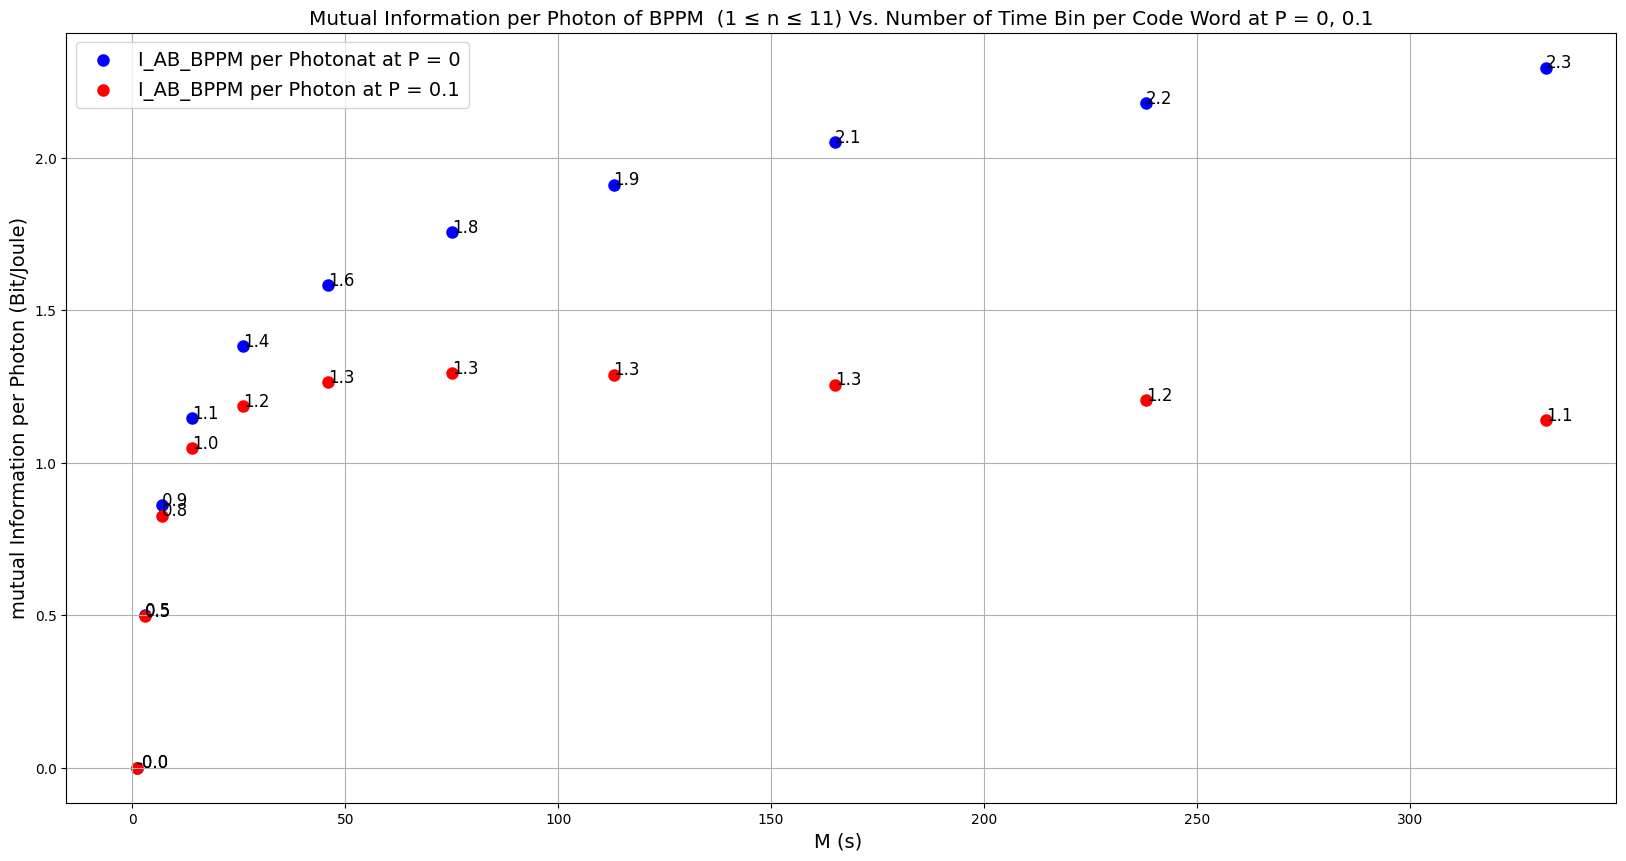

In [16]:
figure, axis = plt.subplots(1,1,figsize=(20,10))

plt.scatter(TimeBin_BPPM_list_0, IperPhoton_AB_BPPM_list_0, label='I_AB_BPPM per Photonat at P = 0', color ='blue', linewidth=3, alpha=1)
plt.scatter(TimeBin_BPPM_list_0_1, IperPhoton_AB_BPPM_list_0_1, label='I_AB_BPPM per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
plt.title('Mutual Information per Photon of BPPM  (1 \u2264 n \u2264 11) Vs. Number of Time Bin per Code Word at P = 0, 0.1', fontsize='x-large')
plt.xlabel('M (s) ', fontsize = 14)
plt.ylabel('mutual Information per Photon (Bit/Joule)', fontsize = 14)
plt.grid(True)
plt.legend(fontsize=14)

for index in range(len(TimeBin_BPPM_list_0)):
  plt.text(TimeBin_BPPM_list_0[index], IperPhoton_AB_BPPM_list_0[index], round(IperPhoton_AB_BPPM_list_0[index],1), size=12)

for index in range(len(TimeBin_BPPM_list_0_1)):
  plt.text(TimeBin_BPPM_list_0_1[index], IperPhoton_AB_BPPM_list_0_1[index], round(IperPhoton_AB_BPPM_list_0_1[index],1), size=12)

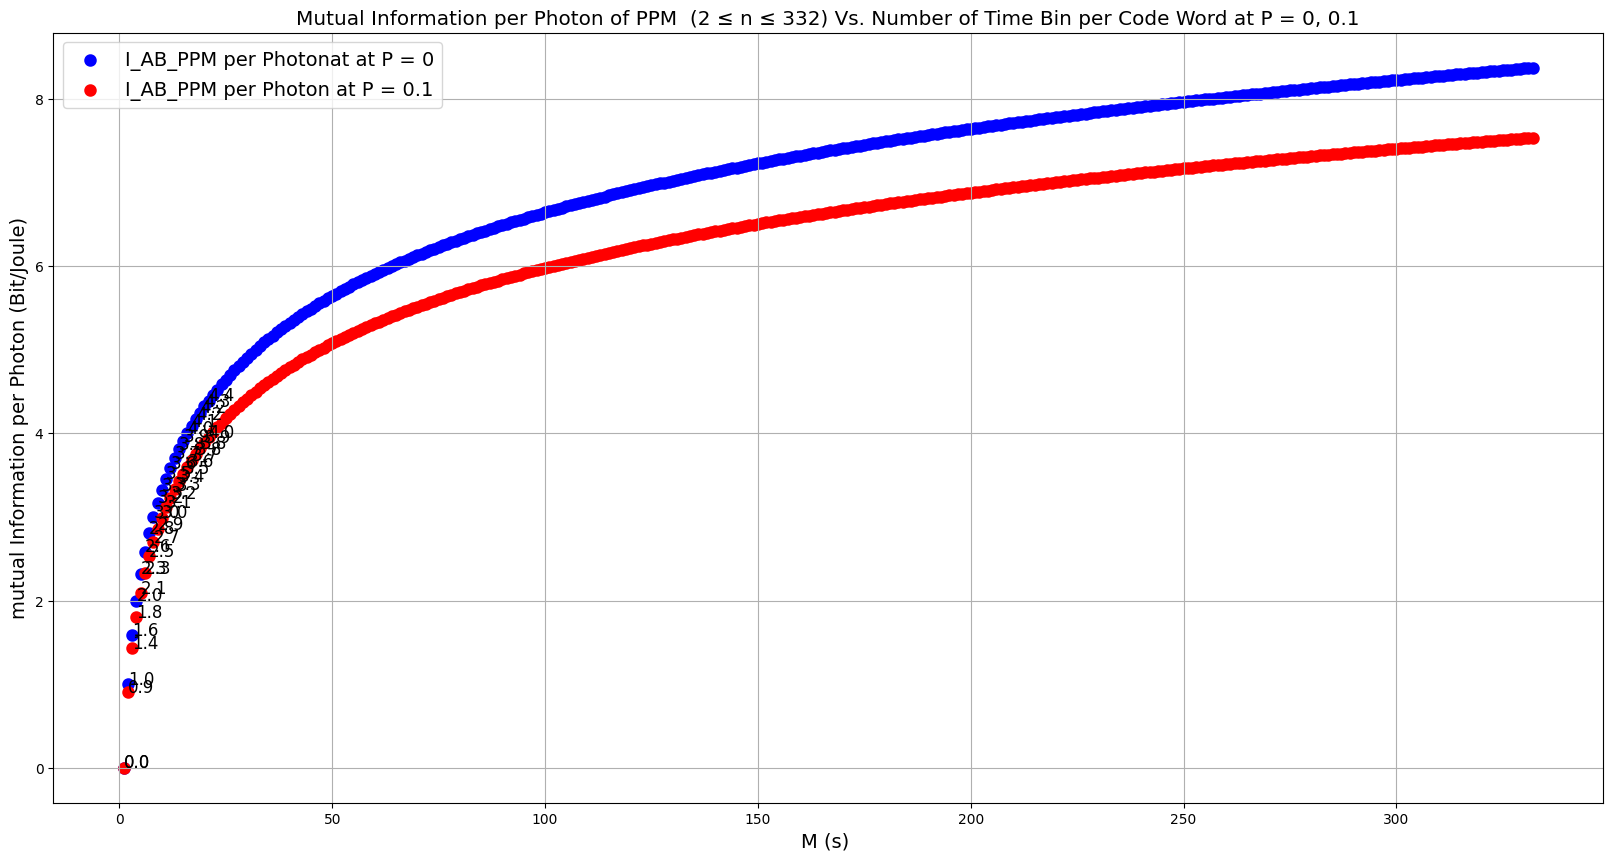

In [17]:
figure, axis = plt.subplots(1,1,figsize=(20,10))

plt.scatter(TimeBin_PPM_list_0, IperPhoton_AB_PPM_list_0, label='I_AB_PPM per Photonat at P = 0', color ='blue', linewidth=3, alpha=1)
plt.scatter(TimeBin_PPM_list_0_1, IperPhoton_AB_PPM_list_0_1, label='I_AB_PPM per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
plt.title('Mutual Information per Photon of PPM  (2 \u2264 n \u2264 332) Vs. Number of Time Bin per Code Word at P = 0, 0.1', fontsize='x-large')
plt.xlabel('M (s) ', fontsize = 14)
plt.ylabel('mutual Information per Photon (Bit/Joule)', fontsize = 14)
plt.grid(True)
plt.legend(fontsize=14)

for index in range(0,21):
  plt.text(TimeBin_PPM_list_0[index], IperPhoton_AB_PPM_list_0[index], round(IperPhoton_AB_PPM_list_0[index],1), size=12)

for index in range(0,21):
  plt.text(TimeBin_PPM_list_0_1[index], IperPhoton_AB_PPM_list_0_1[index], round(IperPhoton_AB_PPM_list_0_1[index],1), size=12)

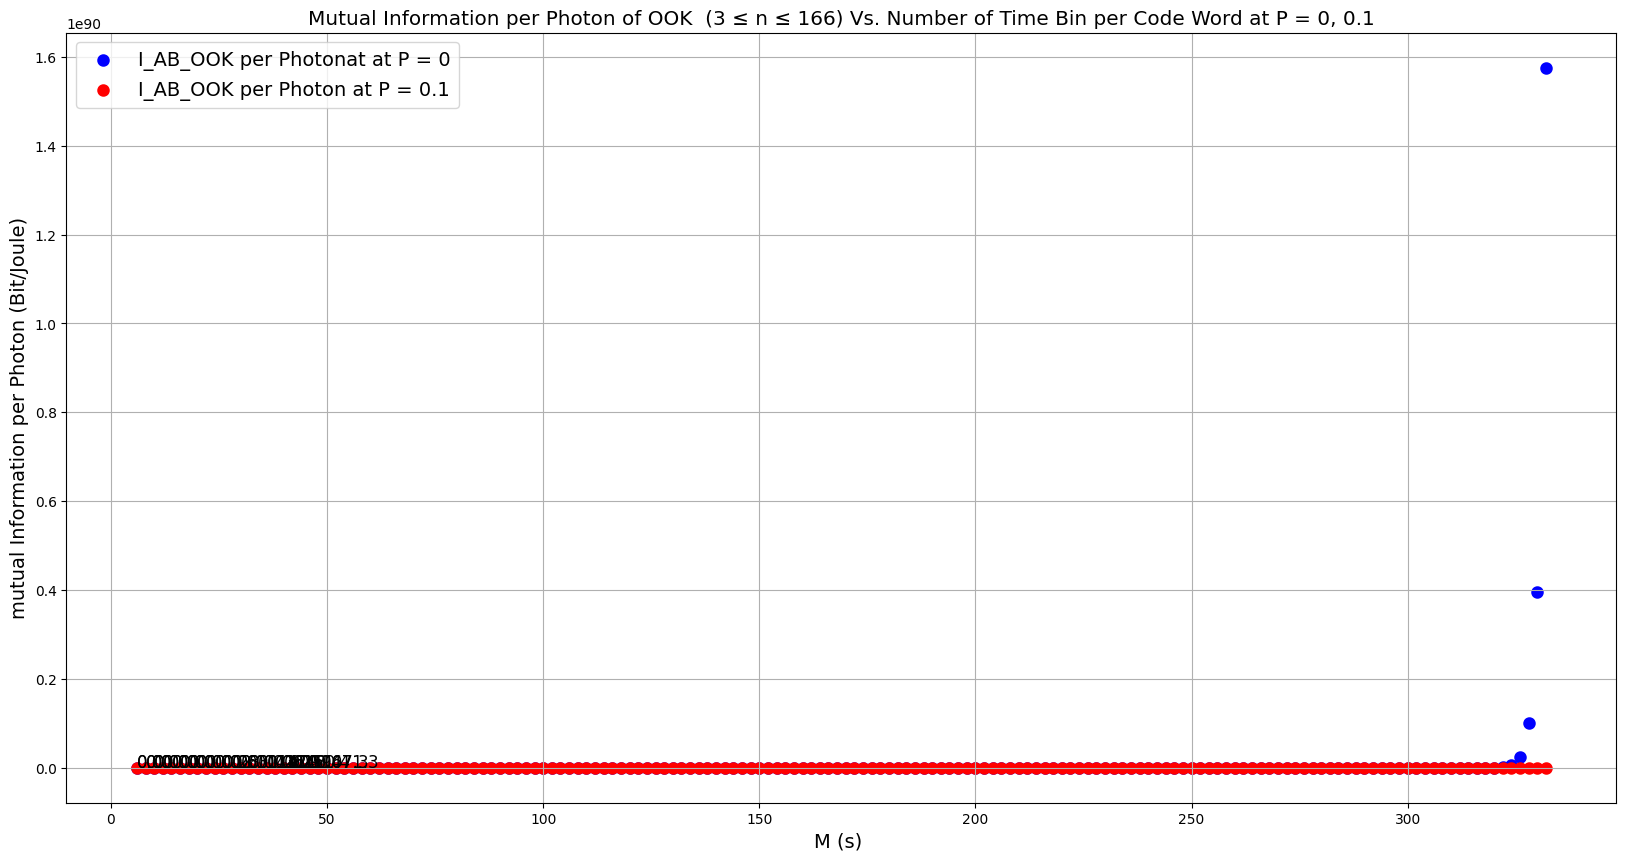

In [18]:
figure, axis = plt.subplots(1,1,figsize=(20,10))

plt.scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photonat at P = 0', color ='blue', linewidth=3, alpha=1)
plt.scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
plt.title('Mutual Information per Photon of OOK  (3 \u2264 n \u2264 166) Vs. Number of Time Bin per Code Word at P = 0, 0.1', fontsize='x-large')
plt.xlabel('M (s) ', fontsize = 14)
plt.ylabel('mutual Information per Photon (Bit/Joule)', fontsize = 14)
plt.grid(True)
plt.legend(fontsize=14)

for index in range(0,21): # len(TimeBin_OOK_list_0)
  plt.text(TimeBin_OOK_list_0[index], IperPhoton_AB_OOK_list_0[index], round(IperPhoton_AB_OOK_list_0[index],1), size=12)

for index in range(0,21): # (len(TimeBin_OOK_list_0_1)
  plt.text(TimeBin_OOK_list_0_1[index], IperPhoton_AB_OOK_list_0_1[index], round(IperPhoton_AB_OOK_list_0_1[index],1), size=12)

### Plot on Mutual Information per Time Bin Vs Time Bin

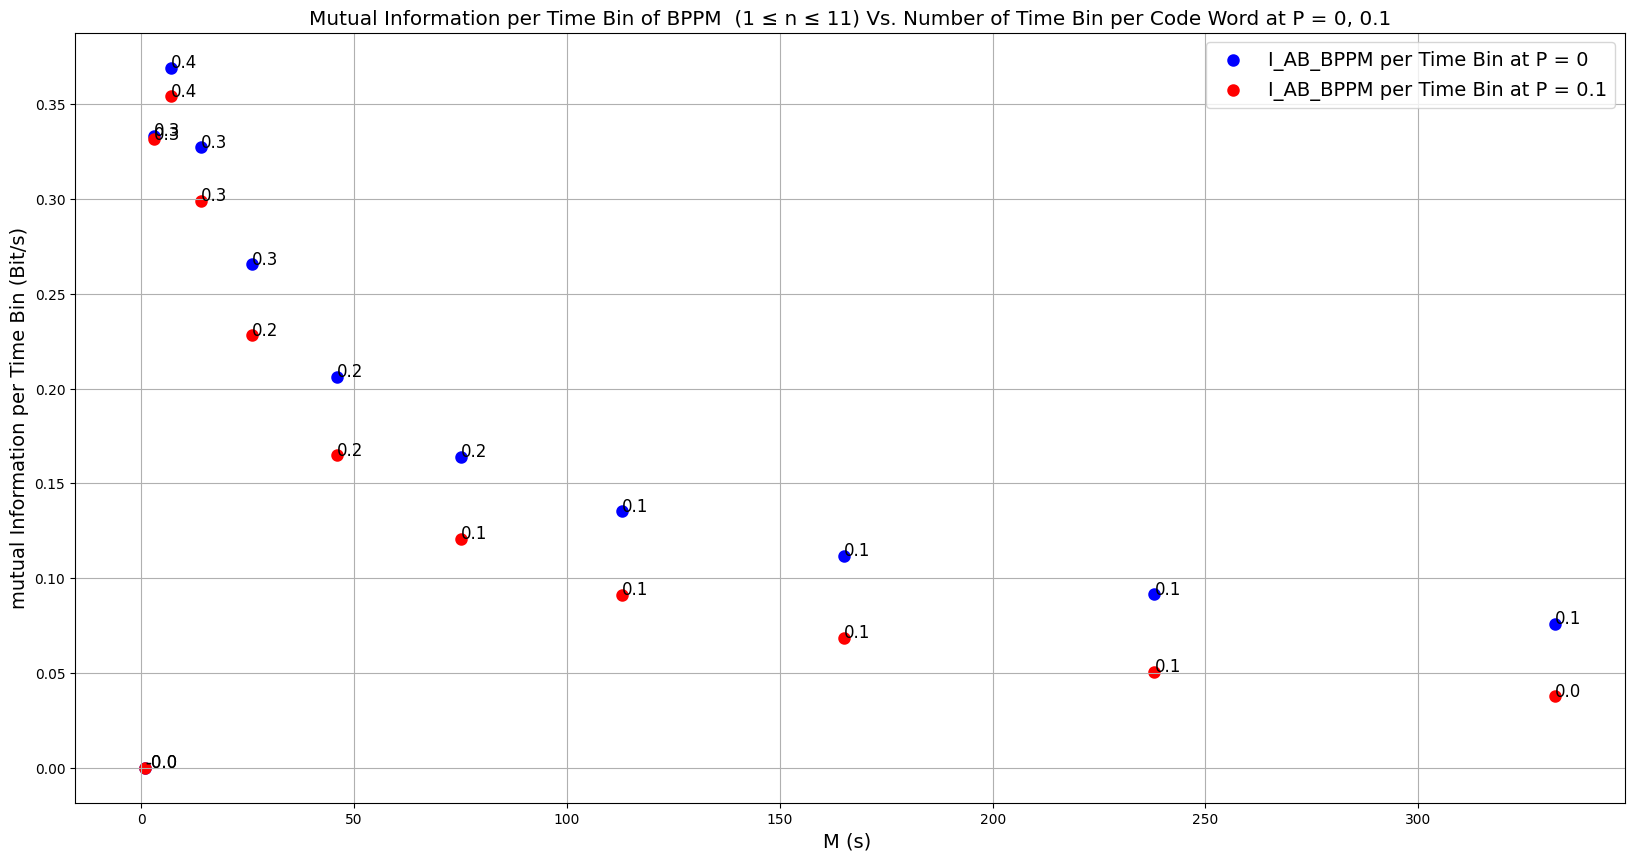

In [19]:
figure, axis = plt.subplots(1,1,figsize=(20,10))

plt.scatter(TimeBin_BPPM_list_0, IperTimeBin_AB_BPPM_list_0, label='I_AB_BPPM per Time Bin at P = 0', color ='blue', linewidth=3, alpha=1)
plt.scatter(TimeBin_BPPM_list_0_1, IperTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM per Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
# plt.plot(P_list, I_AB_General_n2_list_5, label='I_AB_General for 2 Photons', color ='green', linewidth=3, alpha=1)
# plt.plot(P_list, I_AB_General_n3_list_5, label='I_AB_General for 3 Photons',color ='orange', linewidth=3, alpha=1)
plt.title('Mutual Information per Time Bin of BPPM  (1 \u2264 n \u2264 11) Vs. Number of Time Bin per Code Word at P = 0, 0.1', fontsize='x-large')
plt.xlabel('M (s) ', fontsize = 14)
plt.ylabel('mutual Information per Time Bin (Bit/s)', fontsize = 14)
plt.grid(True)
plt.legend(fontsize=14)

for index in range(len(TimeBin_BPPM_list_0)):
  plt.text(TimeBin_BPPM_list_0[index], IperTimeBin_AB_BPPM_list_0[index], round(IperTimeBin_AB_BPPM_list_0[index],1), size=12)

for index in range(len(TimeBin_BPPM_list_0_1)):
  plt.text(TimeBin_BPPM_list_0_1[index], IperTimeBin_AB_BPPM_list_0_1[index], round(IperTimeBin_AB_BPPM_list_0_1[index],1), size=12)

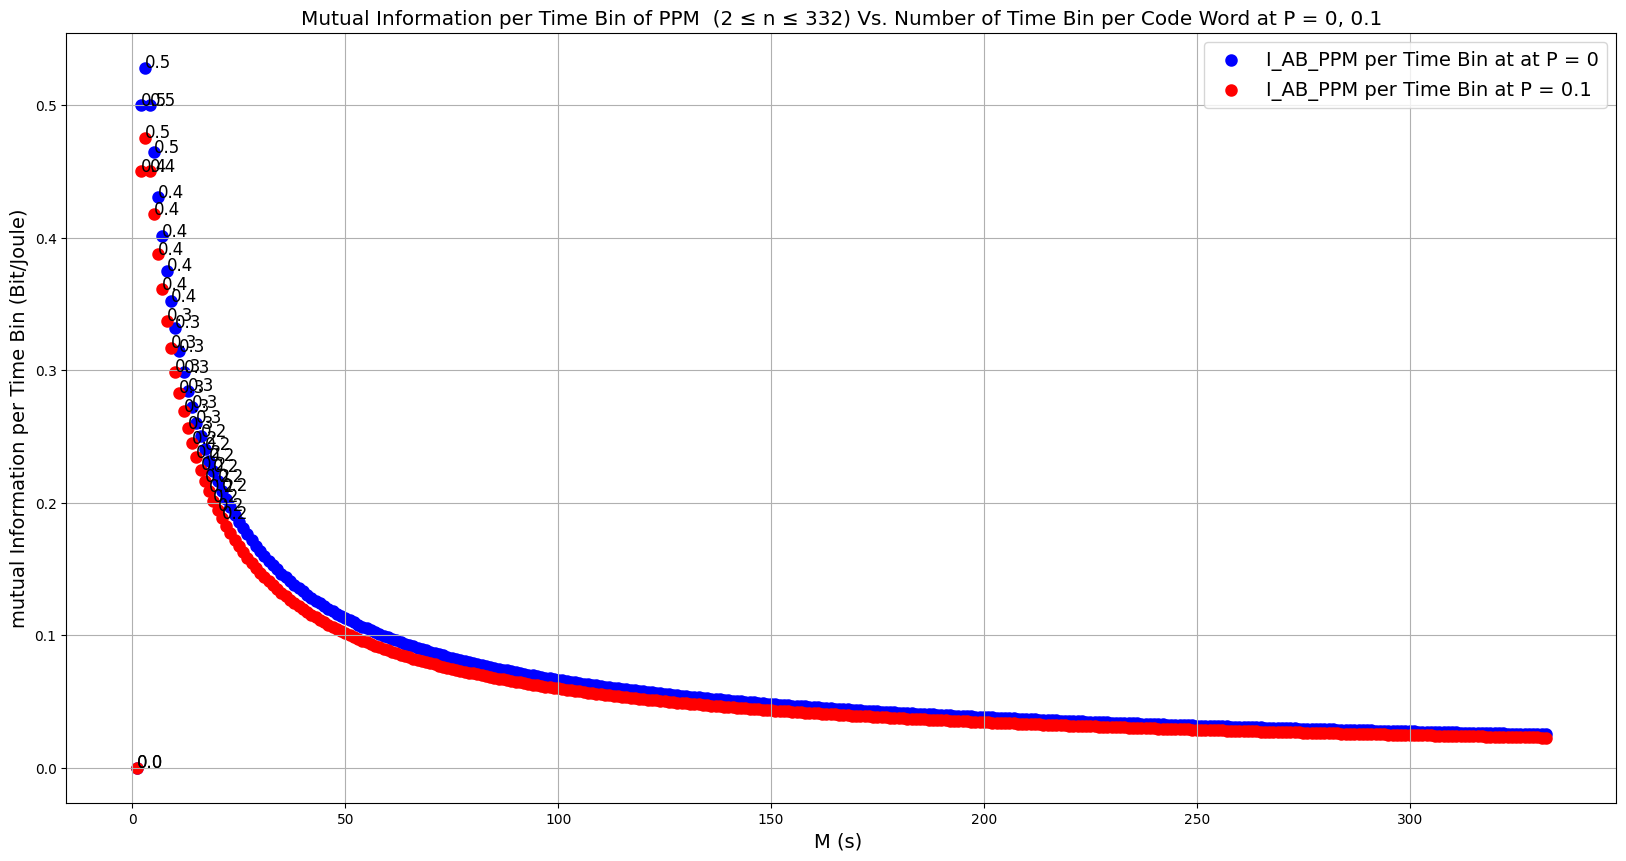

In [20]:
figure, axis = plt.subplots(1,1,figsize=(20,10))

plt.scatter(TimeBin_PPM_list_0, IperTimeBin_AB_PPM_list_0, label='I_AB_PPM per Time Bin at at P = 0', color ='blue', linewidth=3, alpha=1)
plt.scatter(TimeBin_PPM_list_0_1, IperTimeBin_AB_PPM_list_0_1, label='I_AB_PPM per Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
plt.title('Mutual Information per Time Bin of PPM  (2 \u2264 n \u2264 332) Vs. Number of Time Bin per Code Word at P = 0, 0.1', fontsize='x-large')
plt.xlabel('M (s) ', fontsize = 14)
plt.ylabel('mutual Information per Time Bin (Bit/Joule)', fontsize = 14)
plt.grid(True)
plt.legend(fontsize=14)

for index in range(0,21):
  plt.text(TimeBin_PPM_list_0[index], IperTimeBin_AB_PPM_list_0[index], round(IperTimeBin_AB_PPM_list_0[index],1), size=12)

for index in range(0,21):
  plt.text(TimeBin_PPM_list_0_1[index], IperTimeBin_AB_PPM_list_0_1[index], round(IperTimeBin_AB_PPM_list_0_1[index],1), size=12)

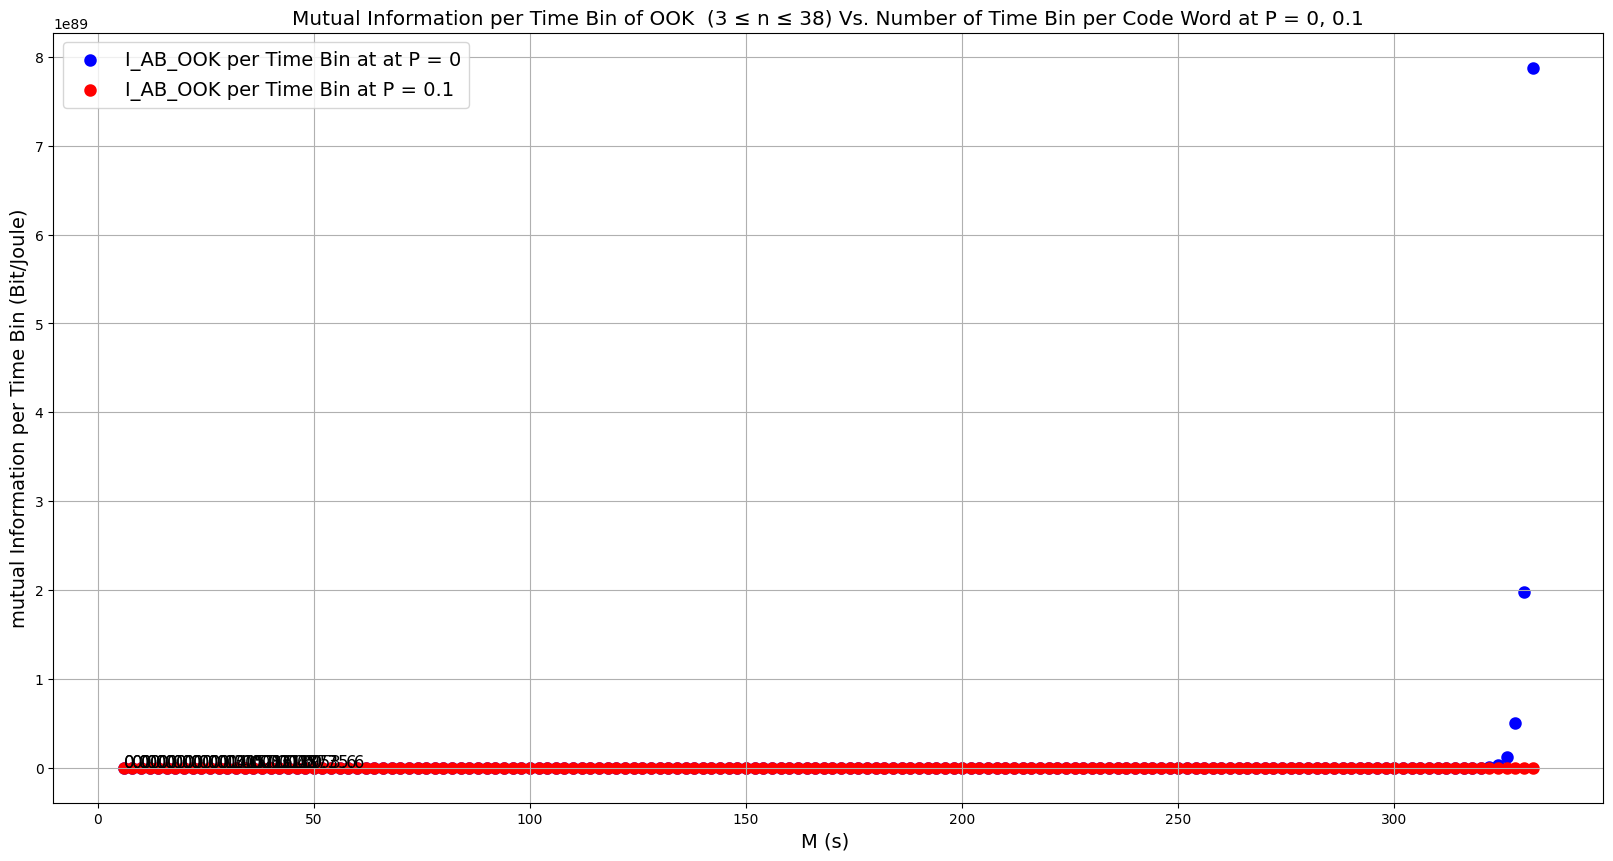

In [21]:
figure, axis = plt.subplots(1,1,figsize=(20,10))

plt.scatter(TimeBin_OOK_list_0, IperTimeBin_AB_OOK_list_0, label='I_AB_OOK per Time Bin at at P = 0', color ='blue', linewidth=3, alpha=1)
plt.scatter(TimeBin_OOK_list_0_1, IperTimeBin_AB_OOK_list_0_1, label='I_AB_OOK per Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
# plt.plot(P_list, I_AB_General_n2_list_5, label='I_AB_General for 2 Photons', color ='green', linewidth=3, alpha=1)
# plt.plot(P_list, I_AB_General_n3_list_5, label='I_AB_General for 3 Photons',color ='orange', linewidth=3, alpha=1)
plt.title('Mutual Information per Time Bin of OOK  (3 \u2264 n \u2264 38) Vs. Number of Time Bin per Code Word at P = 0, 0.1', fontsize='x-large')
plt.xlabel('M (s) ', fontsize = 14)
plt.ylabel('mutual Information per Time Bin (Bit/Joule)', fontsize = 14)
plt.grid(True)
plt.legend(fontsize=14)

for index in range(0,21):
  plt.text(TimeBin_OOK_list_0[index], IperTimeBin_AB_OOK_list_0[index], round(IperTimeBin_AB_OOK_list_0[index],1), size=12)

for index in range(0,21):
  plt.text(TimeBin_OOK_list_0_1[index], IperTimeBin_AB_OOK_list_0_1[index], round(IperTimeBin_AB_OOK_list_0_1[index],1), size=12)

## Combined Plot

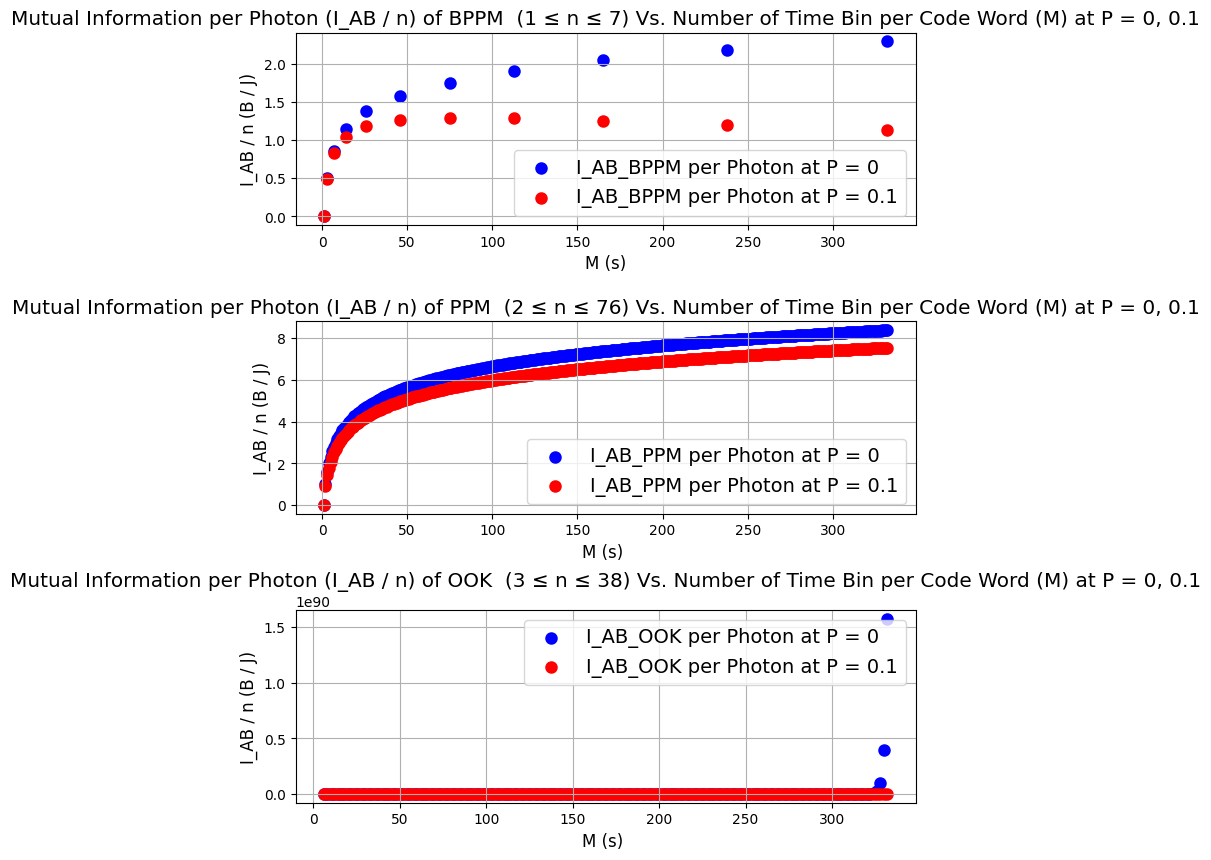

In [22]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))

axs[0].scatter(TimeBin_BPPM_list_0, IperPhoton_AB_BPPM_list_0, label='I_AB_BPPM per Photon at P = 0', color ='blue', linewidth=3, alpha=1)
axs[0].scatter(TimeBin_BPPM_list_0_1, IperPhoton_AB_BPPM_list_0_1, label='I_AB_BPPM per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[0].set_title('Mutual Information per Photon (I_AB / n) of BPPM  (1 \u2264 n \u2264 7) Vs. Number of Time Bin per Code Word (M) at P = 0, 0.1', fontsize='x-large')
axs[0].set_xlabel('M (s)', fontsize = 12)
axs[0].set_ylabel('I_AB / n (B / J)', fontsize = 12)
axs[0].grid(True)
axs[0].legend(fontsize=14)

  
axs[1].scatter(TimeBin_PPM_list_0, IperPhoton_AB_PPM_list_0, label='I_AB_PPM per Photon at P = 0', color ='blue', linewidth=3, alpha=1)
axs[1].scatter(TimeBin_PPM_list_0_1, IperPhoton_AB_PPM_list_0_1, label='I_AB_PPM per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[1].set_title('Mutual Information per Photon (I_AB / n) of PPM  (2 \u2264 n \u2264 76) Vs. Number of Time Bin per Code Word (M) at P = 0, 0.1', fontsize='x-large')
axs[1].set_xlabel('M (s) ', fontsize = 12)
axs[1].set_ylabel('I_AB / n (B / J)', fontsize = 12)
axs[1].grid(True)
axs[1].legend(fontsize=14)

axs[2].scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photon at P = 0', color ='blue', linewidth=3, alpha=1)
axs[2].scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[2].set_title('Mutual Information per Photon (I_AB / n) of OOK  (3 \u2264 n \u2264 38) Vs. Number of Time Bin per Code Word (M) at P = 0, 0.1', fontsize='x-large')
axs[2].set_xlabel('M (s) ', fontsize = 12)
axs[2].set_ylabel('I_AB / n (B / J)', fontsize = 12)
axs[2].grid(True)
axs[2].legend(fontsize=14)

plt.subplots_adjust(hspace=0.5)
figure.set_facecolor("white")
plt.show()

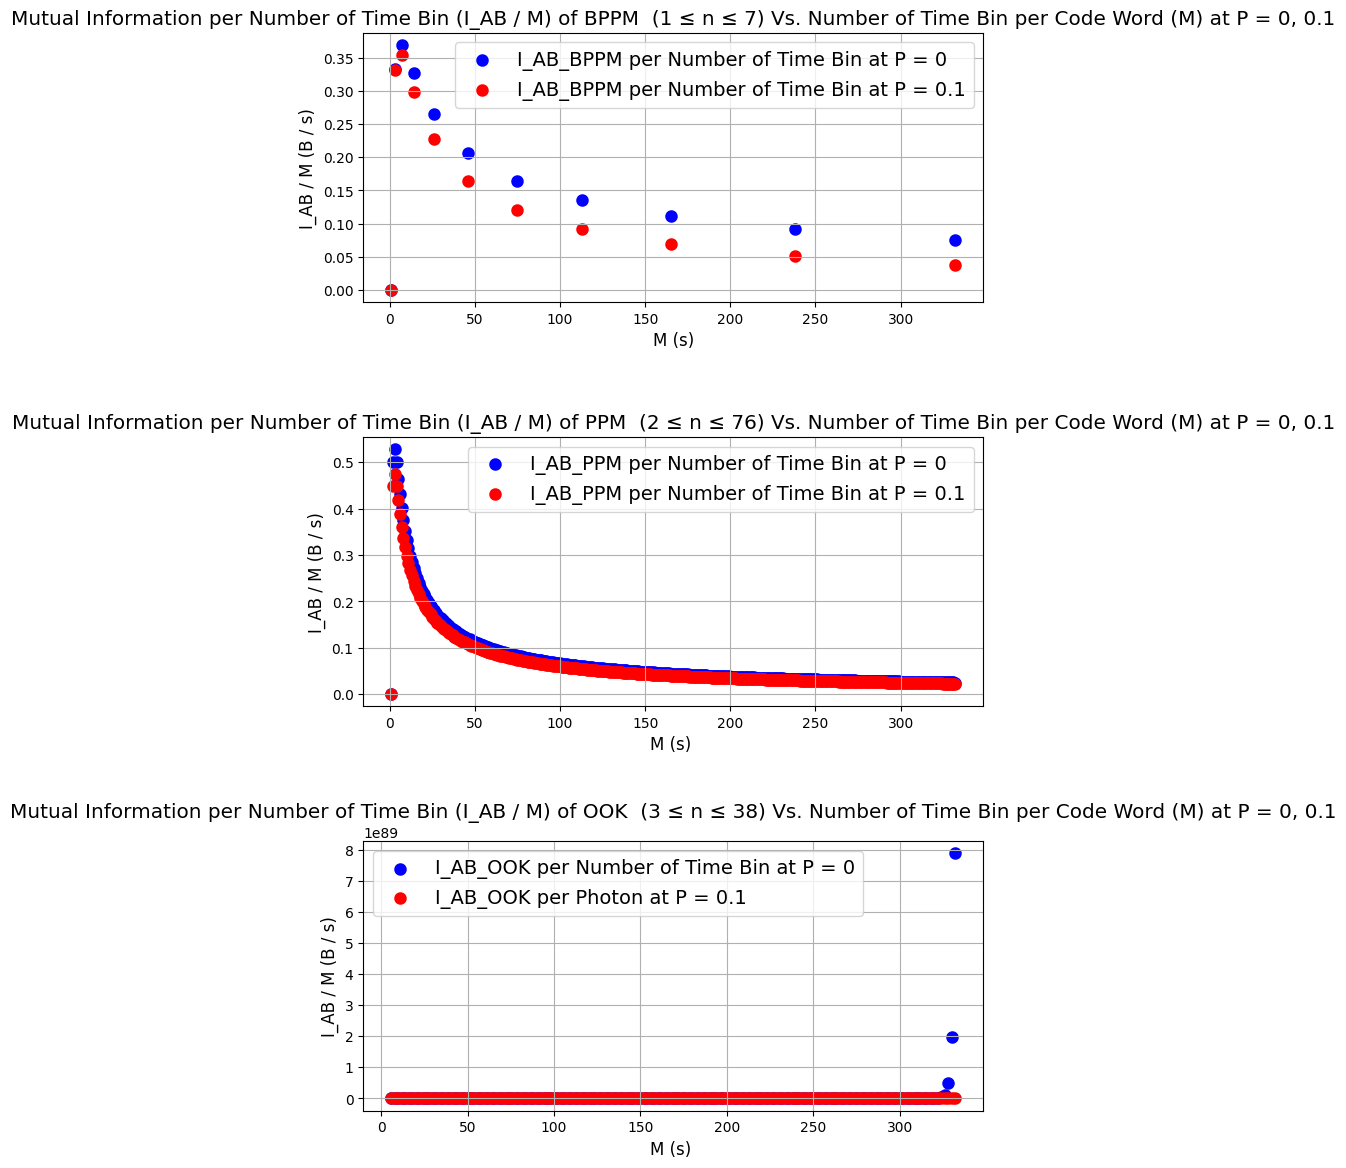

In [23]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 14))

axs[0].scatter(TimeBin_BPPM_list_0, IperTimeBin_AB_BPPM_list_0, label='I_AB_BPPM per Number of Time Bin at P = 0', color ='blue', linewidth=3, alpha=1)
axs[0].scatter(TimeBin_BPPM_list_0_1, IperTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM per Number of Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[0].set_title('Mutual Information per Number of Time Bin (I_AB / M) of BPPM  (1 \u2264 n \u2264 7) Vs. Number of Time Bin per Code Word (M) at P = 0, 0.1', fontsize='x-large')
axs[0].set_xlabel('M (s)', fontsize = 12)
axs[0].set_ylabel('I_AB / M (B / s)', fontsize = 12)
axs[0].grid(True)
axs[0].legend(fontsize=14)

axs[1].scatter(TimeBin_PPM_list_0, IperTimeBin_AB_PPM_list_0, label='I_AB_PPM per Number of Time Bin at P = 0', color ='blue', linewidth=3, alpha=1)
axs[1].scatter(TimeBin_PPM_list_0_1, IperTimeBin_AB_PPM_list_0_1, label='I_AB_PPM per Number of Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[1].set_title('Mutual Information per Number of Time Bin (I_AB / M) of PPM  (2 \u2264 n \u2264 76) Vs. Number of Time Bin per Code Word (M) at P = 0, 0.1', fontsize='x-large')
axs[1].set_xlabel('M (s) ', fontsize = 12)
axs[1].set_ylabel('I_AB / M (B / s)', fontsize = 12)
axs[1].grid(True)
axs[1].legend(fontsize=14)

axs[2].scatter(TimeBin_OOK_list_0, IperTimeBin_AB_OOK_list_0, label='I_AB_OOK per Number of Time Bin at P = 0', color ='blue', linewidth=3, alpha=1)
axs[2].scatter(TimeBin_OOK_list_0_1, IperTimeBin_AB_OOK_list_0_1, label='I_AB_OOK per Photon at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[2].set_title('Mutual Information per Number of Time Bin (I_AB / M) of OOK  (3 \u2264 n \u2264 38) Vs. Number of Time Bin per Code Word (M) at P = 0, 0.1', fontsize='x-large')
axs[2].set_xlabel('M (s) ', fontsize = 12)
axs[2].set_ylabel('I_AB / M (B / s)', fontsize = 12)
axs[2].grid(True)
axs[2].legend(fontsize=14)

plt.subplots_adjust(hspace=0.5)
figure.set_facecolor("white")
plt.show()

### Plot on Mutual Information per Photon x Time Bin Vs Time Bin

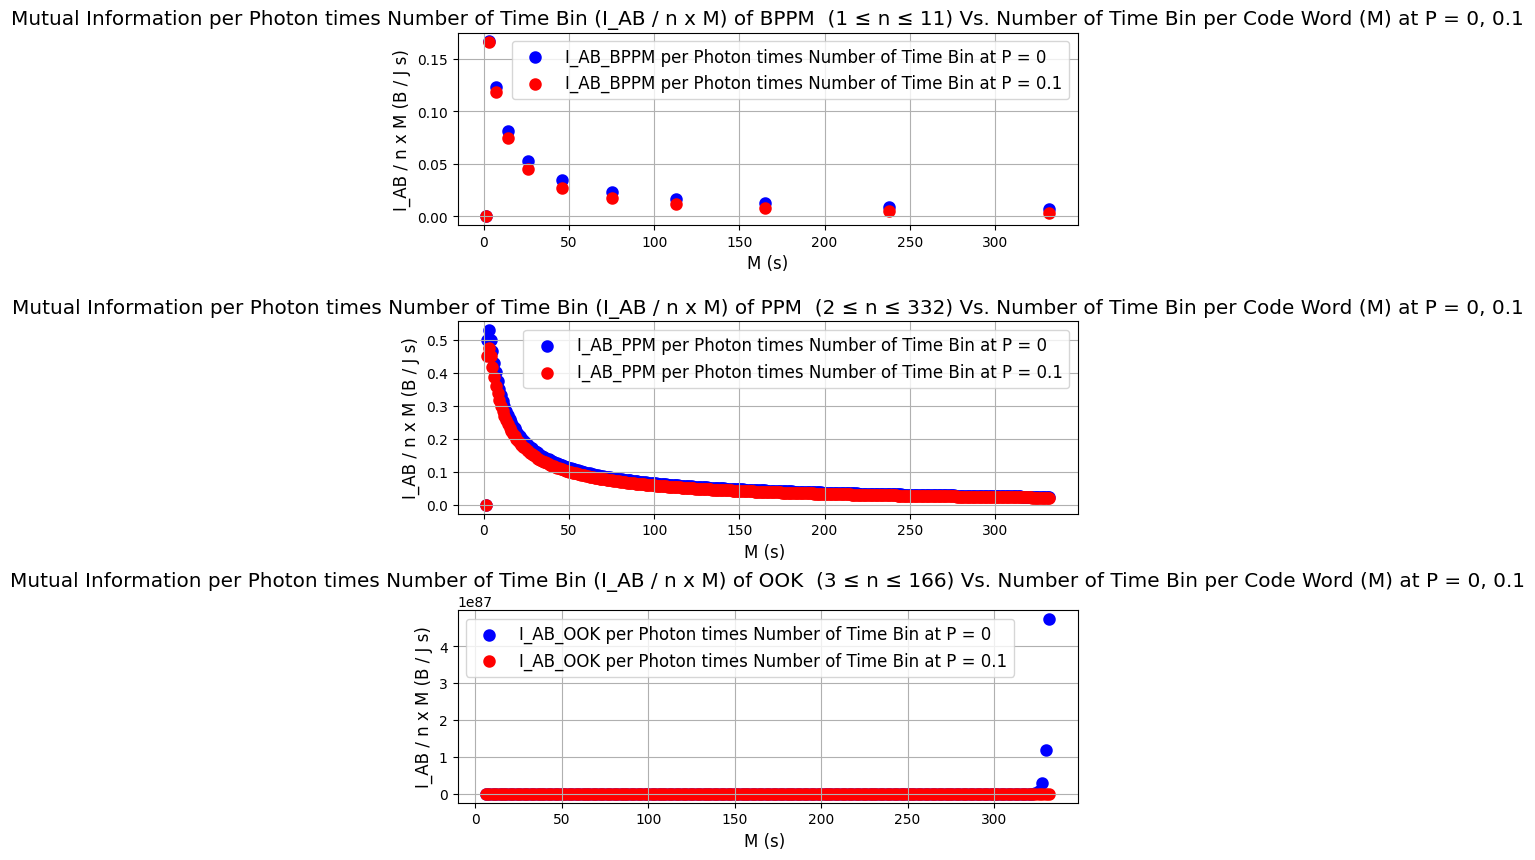

In [24]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(8, 10))

axs[0].scatter(TimeBin_BPPM_list_0, IperPhotonTimeBin_AB_BPPM_list_0, label='I_AB_BPPM per Photon times Number of Time Bin at P = 0', color ='blue', linewidth=3, alpha=1)
axs[0].scatter(TimeBin_BPPM_list_0_1, IperPhotonTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM per Photon times Number of Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[0].set_title('Mutual Information per Photon times Number of Time Bin (I_AB / n x M) of BPPM  (1 \u2264 n \u2264 11) Vs. Number of Time Bin per Code Word (M) at P = 0, 0.1', fontsize='x-large')
axs[0].set_xlabel('M (s)', fontsize = 12)
axs[0].set_ylabel('I_AB / n x M (B / J s)', fontsize = 12)
axs[0].grid(True)
axs[0].legend(fontsize=12)

axs[1].scatter(TimeBin_PPM_list_0, IperPhotonTimeBin_AB_PPM_list_0, label='I_AB_PPM per Photon times Number of Time Bin at P = 0', color ='blue', linewidth=3, alpha=1)
axs[1].scatter(TimeBin_PPM_list_0_1, IperPhotonTimeBin_AB_PPM_list_0_1, label='I_AB_PPM per Photon times Number of Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[1].set_title('Mutual Information per Photon times Number of Time Bin (I_AB / n x M) of PPM  (2 \u2264 n \u2264 332) Vs. Number of Time Bin per Code Word (M) at P = 0, 0.1', fontsize='x-large')
axs[1].set_xlabel('M (s) ', fontsize = 12)
axs[1].set_ylabel('I_AB / n x M (B / J s)', fontsize = 12)
axs[1].grid(True)
axs[1].legend(fontsize=12)

axs[2].scatter(TimeBin_OOK_list_0, IperPhotonTimeBin_AB_OOK_list_0, label='I_AB_OOK per Photon times Number of Time Bin at P = 0', color ='blue', linewidth=3, alpha=1)
axs[2].scatter(TimeBin_OOK_list_0_1, IperPhotonTimeBin_AB_OOK_list_0_1, label='I_AB_OOK per Photon times Number of Time Bin at P = 0.1', color ='red', linewidth=3, alpha=1)
axs[2].set_title('Mutual Information per Photon times Number of Time Bin (I_AB / n x M) of OOK  (3 \u2264 n \u2264 166) Vs. Number of Time Bin per Code Word (M) at P = 0, 0.1', fontsize='x-large')
axs[2].set_xlabel('M (s) ', fontsize = 12)
axs[2].set_ylabel('I_AB / n x M (B / J s)', fontsize = 12)
axs[2].grid(True)
axs[2].legend(fontsize=12)

plt.subplots_adjust(hspace=0.5)
figure.set_facecolor("white")
plt.show()

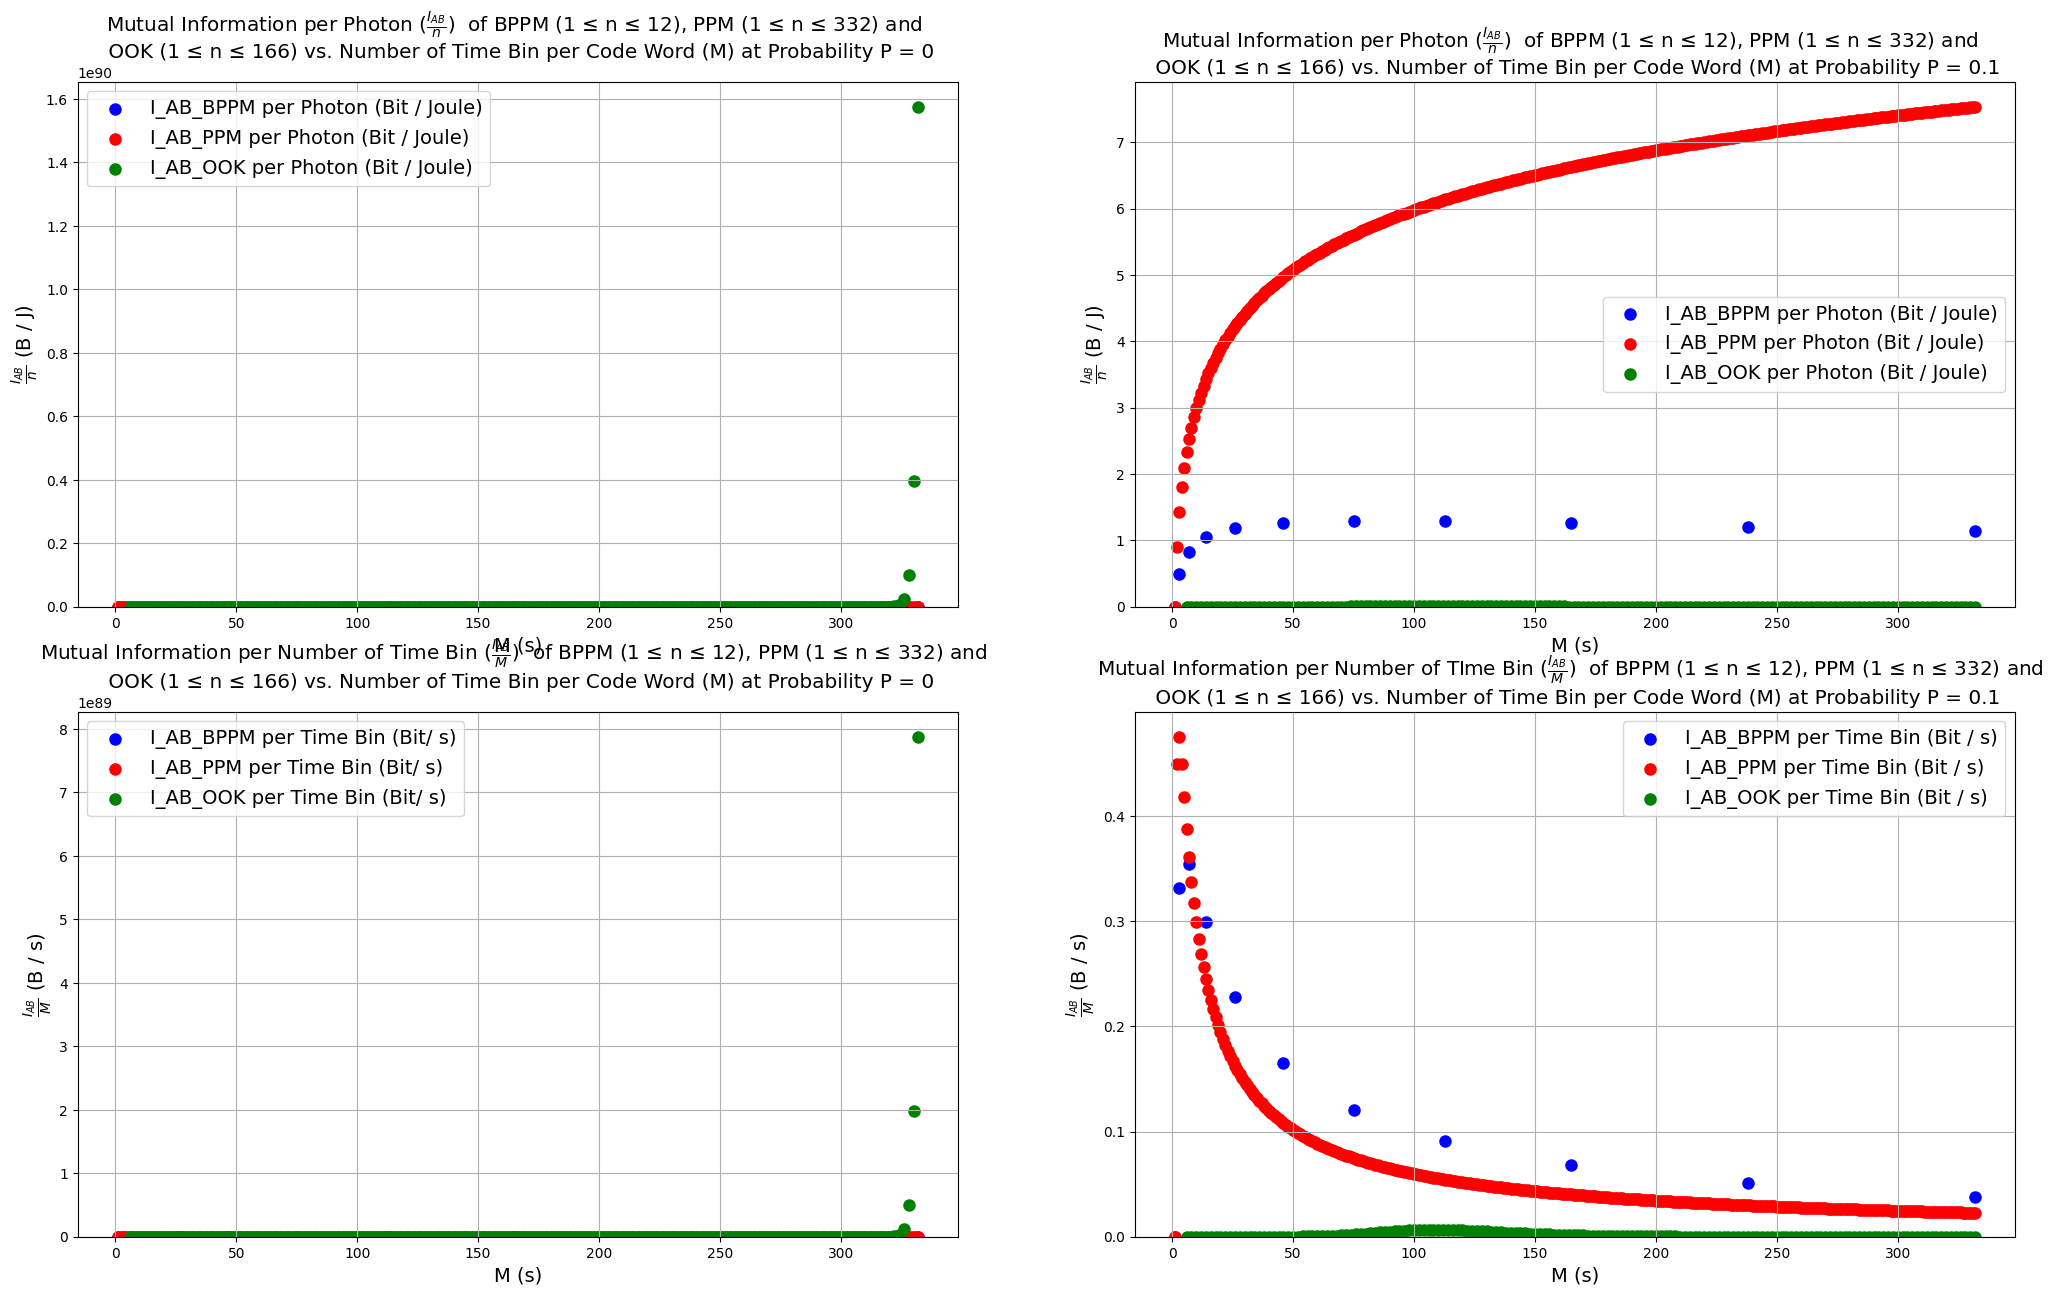

In [25]:
figure, axis = plt.subplots(2,2,figsize=(25,15))

axis[0, 0].scatter(TimeBin_BPPM_list_0, IperPhoton_AB_BPPM_list_0, label='I_AB_BPPM per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_PPM_list_0, IperPhoton_AB_PPM_list_0, label='I_AB_PPM per Photon (Bit / Joule)', color ='red', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photon (Bit / Joule)', color ='green', linewidth=3, alpha=1)
axis[0, 0].set_title('Mutual Information per Photon ($\\frac{I_{AB}}{n}$)  of BPPM (1 \u2264 n \u2264 12), PPM (1 \u2264 n \u2264 332) and  \n OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0', fontsize='x-large')
axis[0, 0].set_xlabel('M (s)', fontsize = 14)
axis[0, 0].set_ylabel('$\\frac{I_{AB}}{n}$ (B / J)', fontsize = 14)
# axis[0, 0].set_xscale('log')
axis[0, 0].set_ylim(0)
axis[0, 0].grid(True)
axis[0, 0].legend(fontsize=14)

axis[0, 1].scatter(TimeBin_BPPM_list_0_1, IperPhoton_AB_BPPM_list_0_1, label='I_AB_BPPM per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_PPM_list_0_1, IperPhoton_AB_PPM_list_0_1, label='I_AB_PPM per Photon (Bit / Joule)', color ='red', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK per Photon (Bit / Joule)', color ='green', linewidth=3, alpha=1)
axs[2].scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 1].set_title('Mutual Information per Photon ($\\frac{I_{AB}}{n}$)  of BPPM (1 \u2264 n \u2264 12), PPM (1 \u2264 n \u2264 332) and  \n OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0.1', fontsize='x-large')
axis[0, 1].set_xlabel('M (s)', fontsize = 14)
axis[0, 1].set_ylabel('$\\frac{I_{AB}}{n}$ (B / J)', fontsize = 14)
# axis[0, 1].set_xscale('log')
axis[0, 1].set_ylim(0)
axis[0, 1].grid(True)
axis[0, 1].legend(fontsize=14)

axis[1, 0].scatter(TimeBin_BPPM_list_0, IperTimeBin_AB_BPPM_list_0, label='I_AB_BPPM per Time Bin (Bit/ s)', color ='blue', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_PPM_list_0, IperTimeBin_AB_PPM_list_0, label='I_AB_PPM per Time Bin (Bit/ s)', color ='red', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_OOK_list_0, IperTimeBin_AB_OOK_list_0, label='I_AB_OOK per Time Bin (Bit/ s)', color ='green', linewidth=3, alpha=1)
axis[1, 0].set_title('Mutual Information per Number of Time Bin ($\\frac{I_{AB}}{M}$)  of BPPM (1 \u2264 n \u2264 12), PPM (1 \u2264 n \u2264 332) and  \n OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0', fontsize='x-large')
axis[1, 0].set_xlabel('M (s)', fontsize = 14)
axis[1, 0].set_ylabel('$\\frac{I_{AB}}{M}$ (B / s)', fontsize = 14)
# axis[1, 0].set_xscale('log')
axis[1, 0].set_ylim(0)
axis[1, 0].grid(True)
axis[1, 0].legend(fontsize=14)

axis[1, 1].scatter(TimeBin_BPPM_list_0_1, IperTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM per Time Bin (Bit / s)', color ='blue', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_PPM_list_0_1, IperTimeBin_AB_PPM_list_0_1, label='I_AB_PPM per Time Bin (Bit / s)', color ='red', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_OOK_list_0_1, IperTimeBin_AB_OOK_list_0_1, label='I_AB_OOK per Time Bin (Bit / s)', color ='green', linewidth=3, alpha=1)
axis[1, 1].set_title('Mutual Information per Number of TIme Bin ($\\frac{I_{AB}}{M}$)  of BPPM (1 \u2264 n \u2264 12), PPM (1 \u2264 n \u2264 332) and  \n OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0.1', fontsize='x-large')
axis[1, 1].set_xlabel('M (s)', fontsize = 14)
axis[1, 1].set_ylabel('$\\frac{I_{AB}}{M}$ (B / s)', fontsize = 14)
# axis[1, 1].set_xscale('log')
axis[1, 1].set_ylim(0)
axis[1, 1].grid(True)
axis[1, 1].legend(fontsize=14)

figure.set_facecolor("white")
# plt.savefig('protocol/MI_Power_4schemes_Plot.png', dpi=450, bbox_inches='tight')
plt.show()

/Users/daai6ga1hou2/anaconda3/envs/qkd-env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: AutoMinorLocator does not work on logarithmic scales
  fig.canvas.print_figure(bytes_io, **kw)


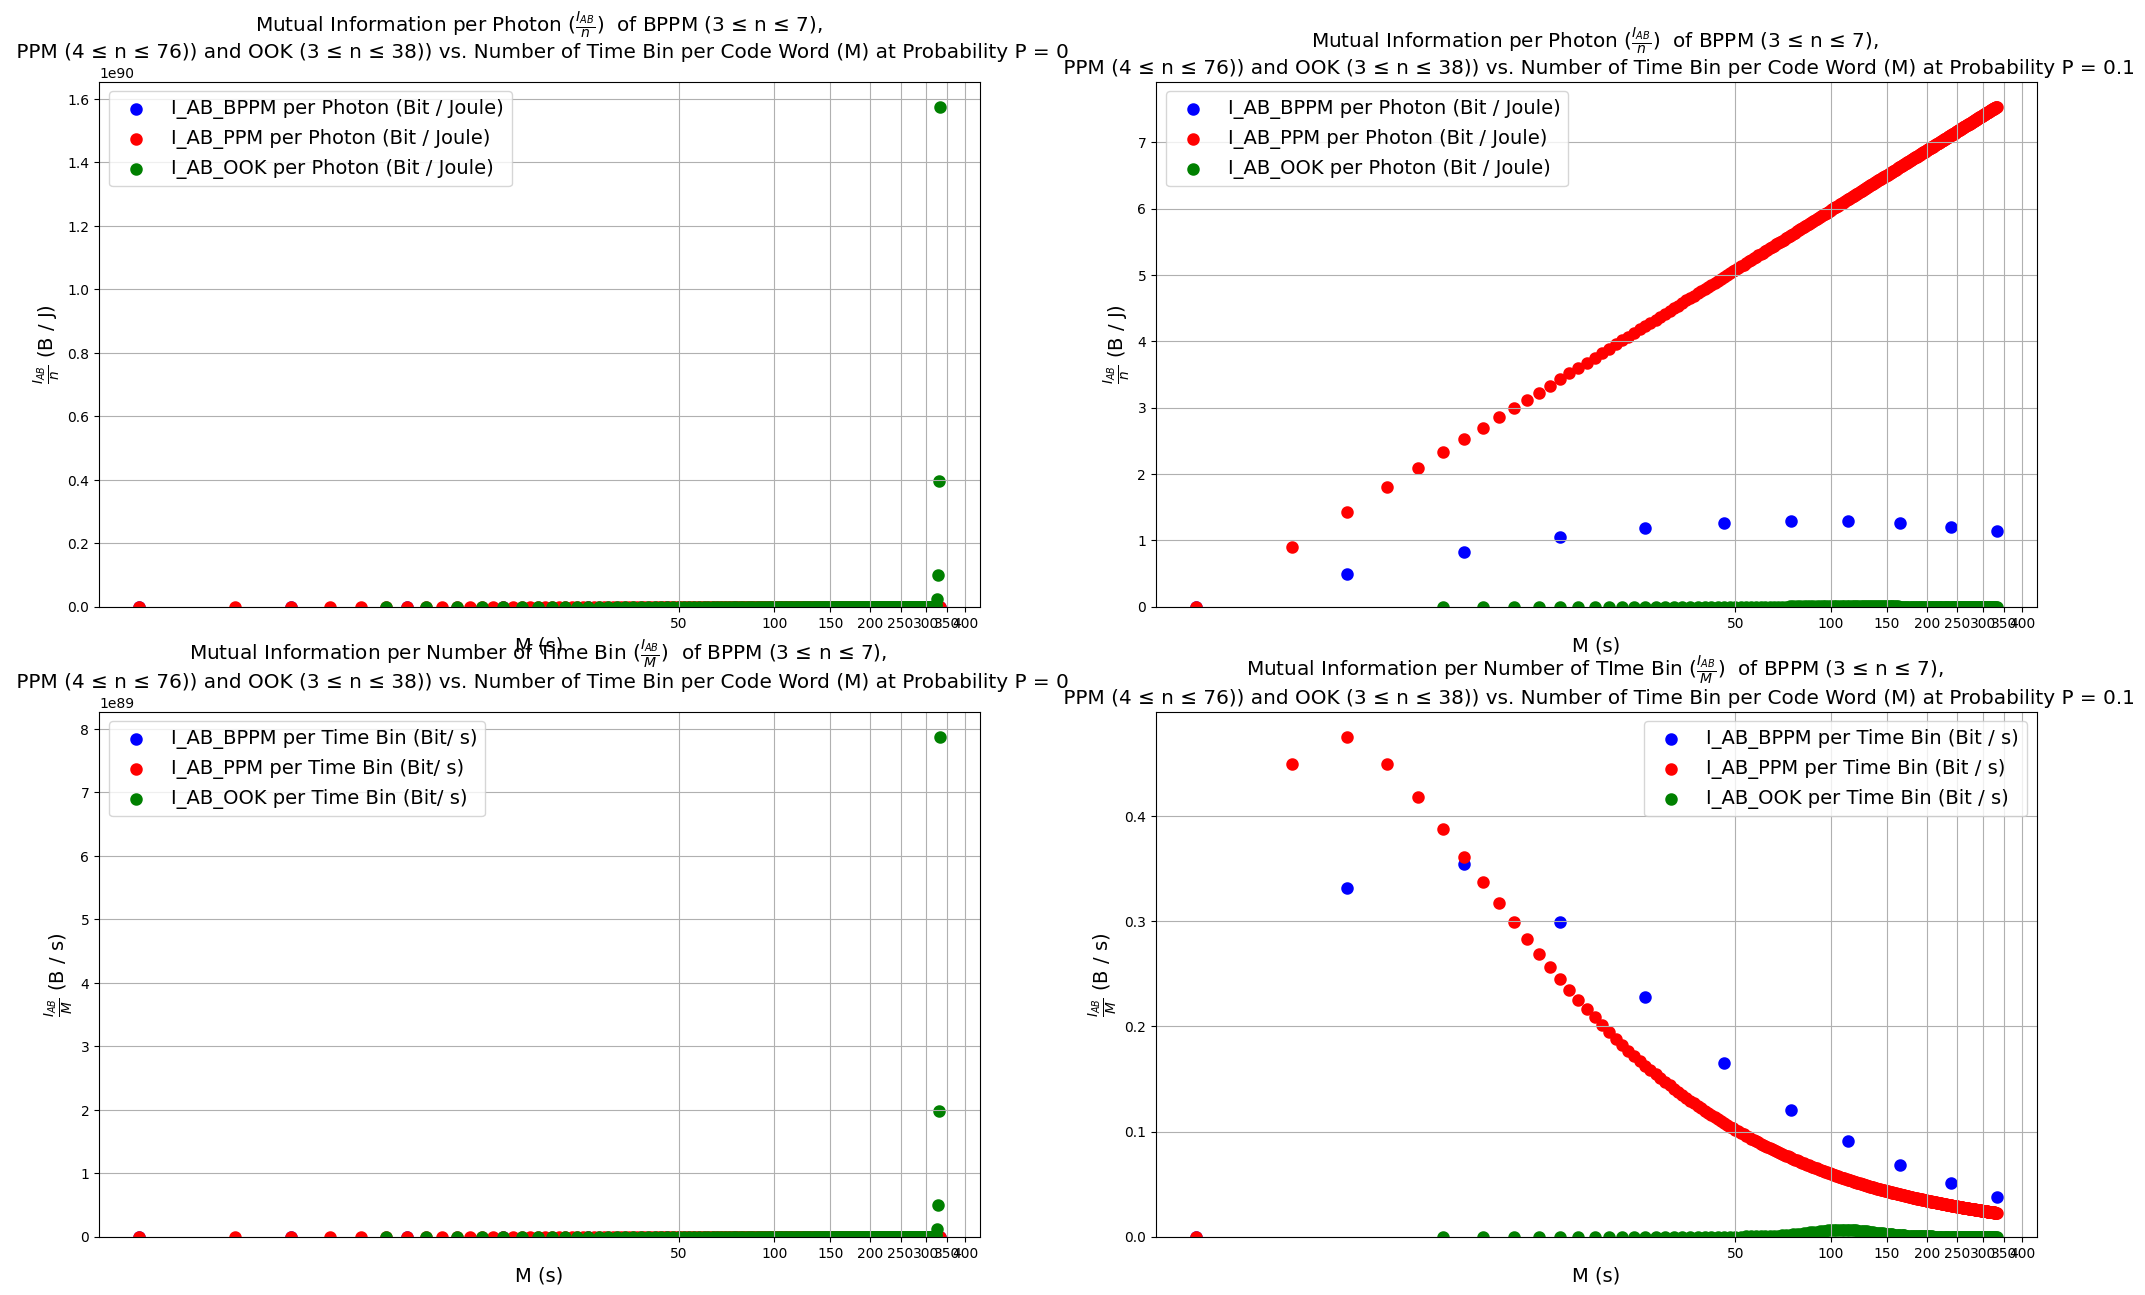

In [26]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import AutoLocator, AutoMinorLocator

# Set the tick formatter for the x-axis
formatter = ScalarFormatter(useOffset=False)

figure, axis = plt.subplots(2,2,figsize=(25,15))

axis[0, 0].scatter(TimeBin_BPPM_list_0, IperPhoton_AB_BPPM_list_0, label='I_AB_BPPM per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_PPM_list_0, IperPhoton_AB_PPM_list_0, label='I_AB_PPM per Photon (Bit / Joule)', color ='red', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photon (Bit / Joule)', color ='green', linewidth=3, alpha=1)

axis[0, 0].set_xscale('log')
axis[0, 0].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[0, 0].xaxis.set_major_locator(AutoLocator())
axis[0, 0].xaxis.set_minor_locator(AutoMinorLocator())
axis[0, 0].xaxis.set_tick_params(which='both', labelsize=10)

axis[0, 0].set_title('Mutual Information per Photon ($\\frac{I_{AB}}{n}$)  of BPPM (3 \u2264 n \u2264 7), \n PPM (4 \u2264 n \u2264 76)) and OOK (3 \u2264 n \u2264 38)) vs. Number of Time Bin per Code Word (M) at Probability P = 0', fontsize='x-large')
axis[0, 0].set_xlabel('M (s)', fontsize = 14)
axis[0, 0].set_ylabel('$\\frac{I_{AB}}{n}$ (B / J)', fontsize = 14)
axis[0, 0].set_ylim(0)
axis[0, 0].grid(True)
axis[0, 0].legend(fontsize=14)

axis[0, 1].scatter(TimeBin_BPPM_list_0_1, IperPhoton_AB_BPPM_list_0_1, label='I_AB_BPPM per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_PPM_list_0_1, IperPhoton_AB_PPM_list_0_1, label='I_AB_PPM per Photon (Bit / Joule)', color ='red', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK per Photon (Bit / Joule)', color ='green', linewidth=3, alpha=1)

axis[0, 1].set_xscale('log')
axis[0, 1].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[0, 1].xaxis.set_major_locator(AutoLocator())
axis[0, 1].xaxis.set_minor_locator(AutoMinorLocator())
axis[0, 1].xaxis.set_tick_params(which='both', labelsize=10)

axis[0, 1].set_title('Mutual Information per Photon ($\\frac{I_{AB}}{n}$)  of BPPM (3 \u2264 n \u2264 7), \n PPM (4 \u2264 n \u2264 76)) and OOK (3 \u2264 n \u2264 38)) vs. Number of Time Bin per Code Word (M) at Probability P = 0.1', fontsize='x-large')
axis[0, 1].set_xlabel('M (s)', fontsize = 14)
axis[0, 1].set_ylabel('$\\frac{I_{AB}}{n}$ (B / J)', fontsize = 14)
axis[0, 1].set_ylim(0)
axis[0, 1].grid(True)
axis[0, 1].legend(fontsize=14)

axis[1, 0].scatter(TimeBin_BPPM_list_0, IperTimeBin_AB_BPPM_list_0, label='I_AB_BPPM per Time Bin (Bit/ s)', color ='blue', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_PPM_list_0, IperTimeBin_AB_PPM_list_0, label='I_AB_PPM per Time Bin (Bit/ s)', color ='red', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_OOK_list_0, IperTimeBin_AB_OOK_list_0, label='I_AB_OOK per Time Bin (Bit/ s)', color ='green', linewidth=3, alpha=1)

axis[1, 0].set_xscale('log')
axis[1, 0].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[1, 0].xaxis.set_major_locator(AutoLocator())
axis[1, 0].xaxis.set_minor_locator(AutoMinorLocator())
axis[1, 0].xaxis.set_tick_params(which='both', labelsize=10)

axis[1, 0].set_title('Mutual Information per Number of Time Bin ($\\frac{I_{AB}}{M}$)  of BPPM (3 \u2264 n \u2264 7), \n PPM (4 \u2264 n \u2264 76)) and OOK (3 \u2264 n \u2264 38)) vs. Number of Time Bin per Code Word (M) at Probability P = 0', fontsize='x-large')
axis[1, 0].set_xlabel('M (s)', fontsize = 14)
axis[1, 0].set_ylabel('$\\frac{I_{AB}}{M}$ (B / s)', fontsize = 14)
axis[1, 0].set_ylim(0)
axis[1, 0].grid(True)
axis[1, 0].legend(loc='upper left',fontsize=14)

axis[1, 1].scatter(TimeBin_BPPM_list_0_1, IperTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM per Time Bin (Bit / s)', color ='blue', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_PPM_list_0_1, IperTimeBin_AB_PPM_list_0_1, label='I_AB_PPM per Time Bin (Bit / s)', color ='red', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_OOK_list_0_1, IperTimeBin_AB_OOK_list_0_1, label='I_AB_OOK per Time Bin (Bit / s)', color ='green', linewidth=3, alpha=1)
axis[1, 1].set_xscale('log')
axis[1, 1].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[1, 1].xaxis.set_major_locator(AutoLocator())
axis[1, 1].xaxis.set_minor_locator(AutoMinorLocator())
axis[1, 1].xaxis.set_tick_params(which='both', labelsize=10)

axis[1, 1].set_title('Mutual Information per Number of TIme Bin ($\\frac{I_{AB}}{M}$)  of BPPM (3 \u2264 n \u2264 7), \n PPM (4 \u2264 n \u2264 76)) and OOK (3 \u2264 n \u2264 38)) vs. Number of Time Bin per Code Word (M) at Probability P = 0.1', fontsize='x-large')
axis[1, 1].set_xlabel('M (s)', fontsize = 14)
axis[1, 1].set_ylabel('$\\frac{I_{AB}}{M}$ (B / s)', fontsize = 14)

axis[1, 1].set_ylim(0)
axis[1, 1].grid(True)
axis[1, 1].legend(fontsize=14)

figure.set_facecolor("white")
# plt.savefig('protocol/MI_Power_4schemes_Plot.png', dpi=450, bbox_inches='tight')
plt.show()

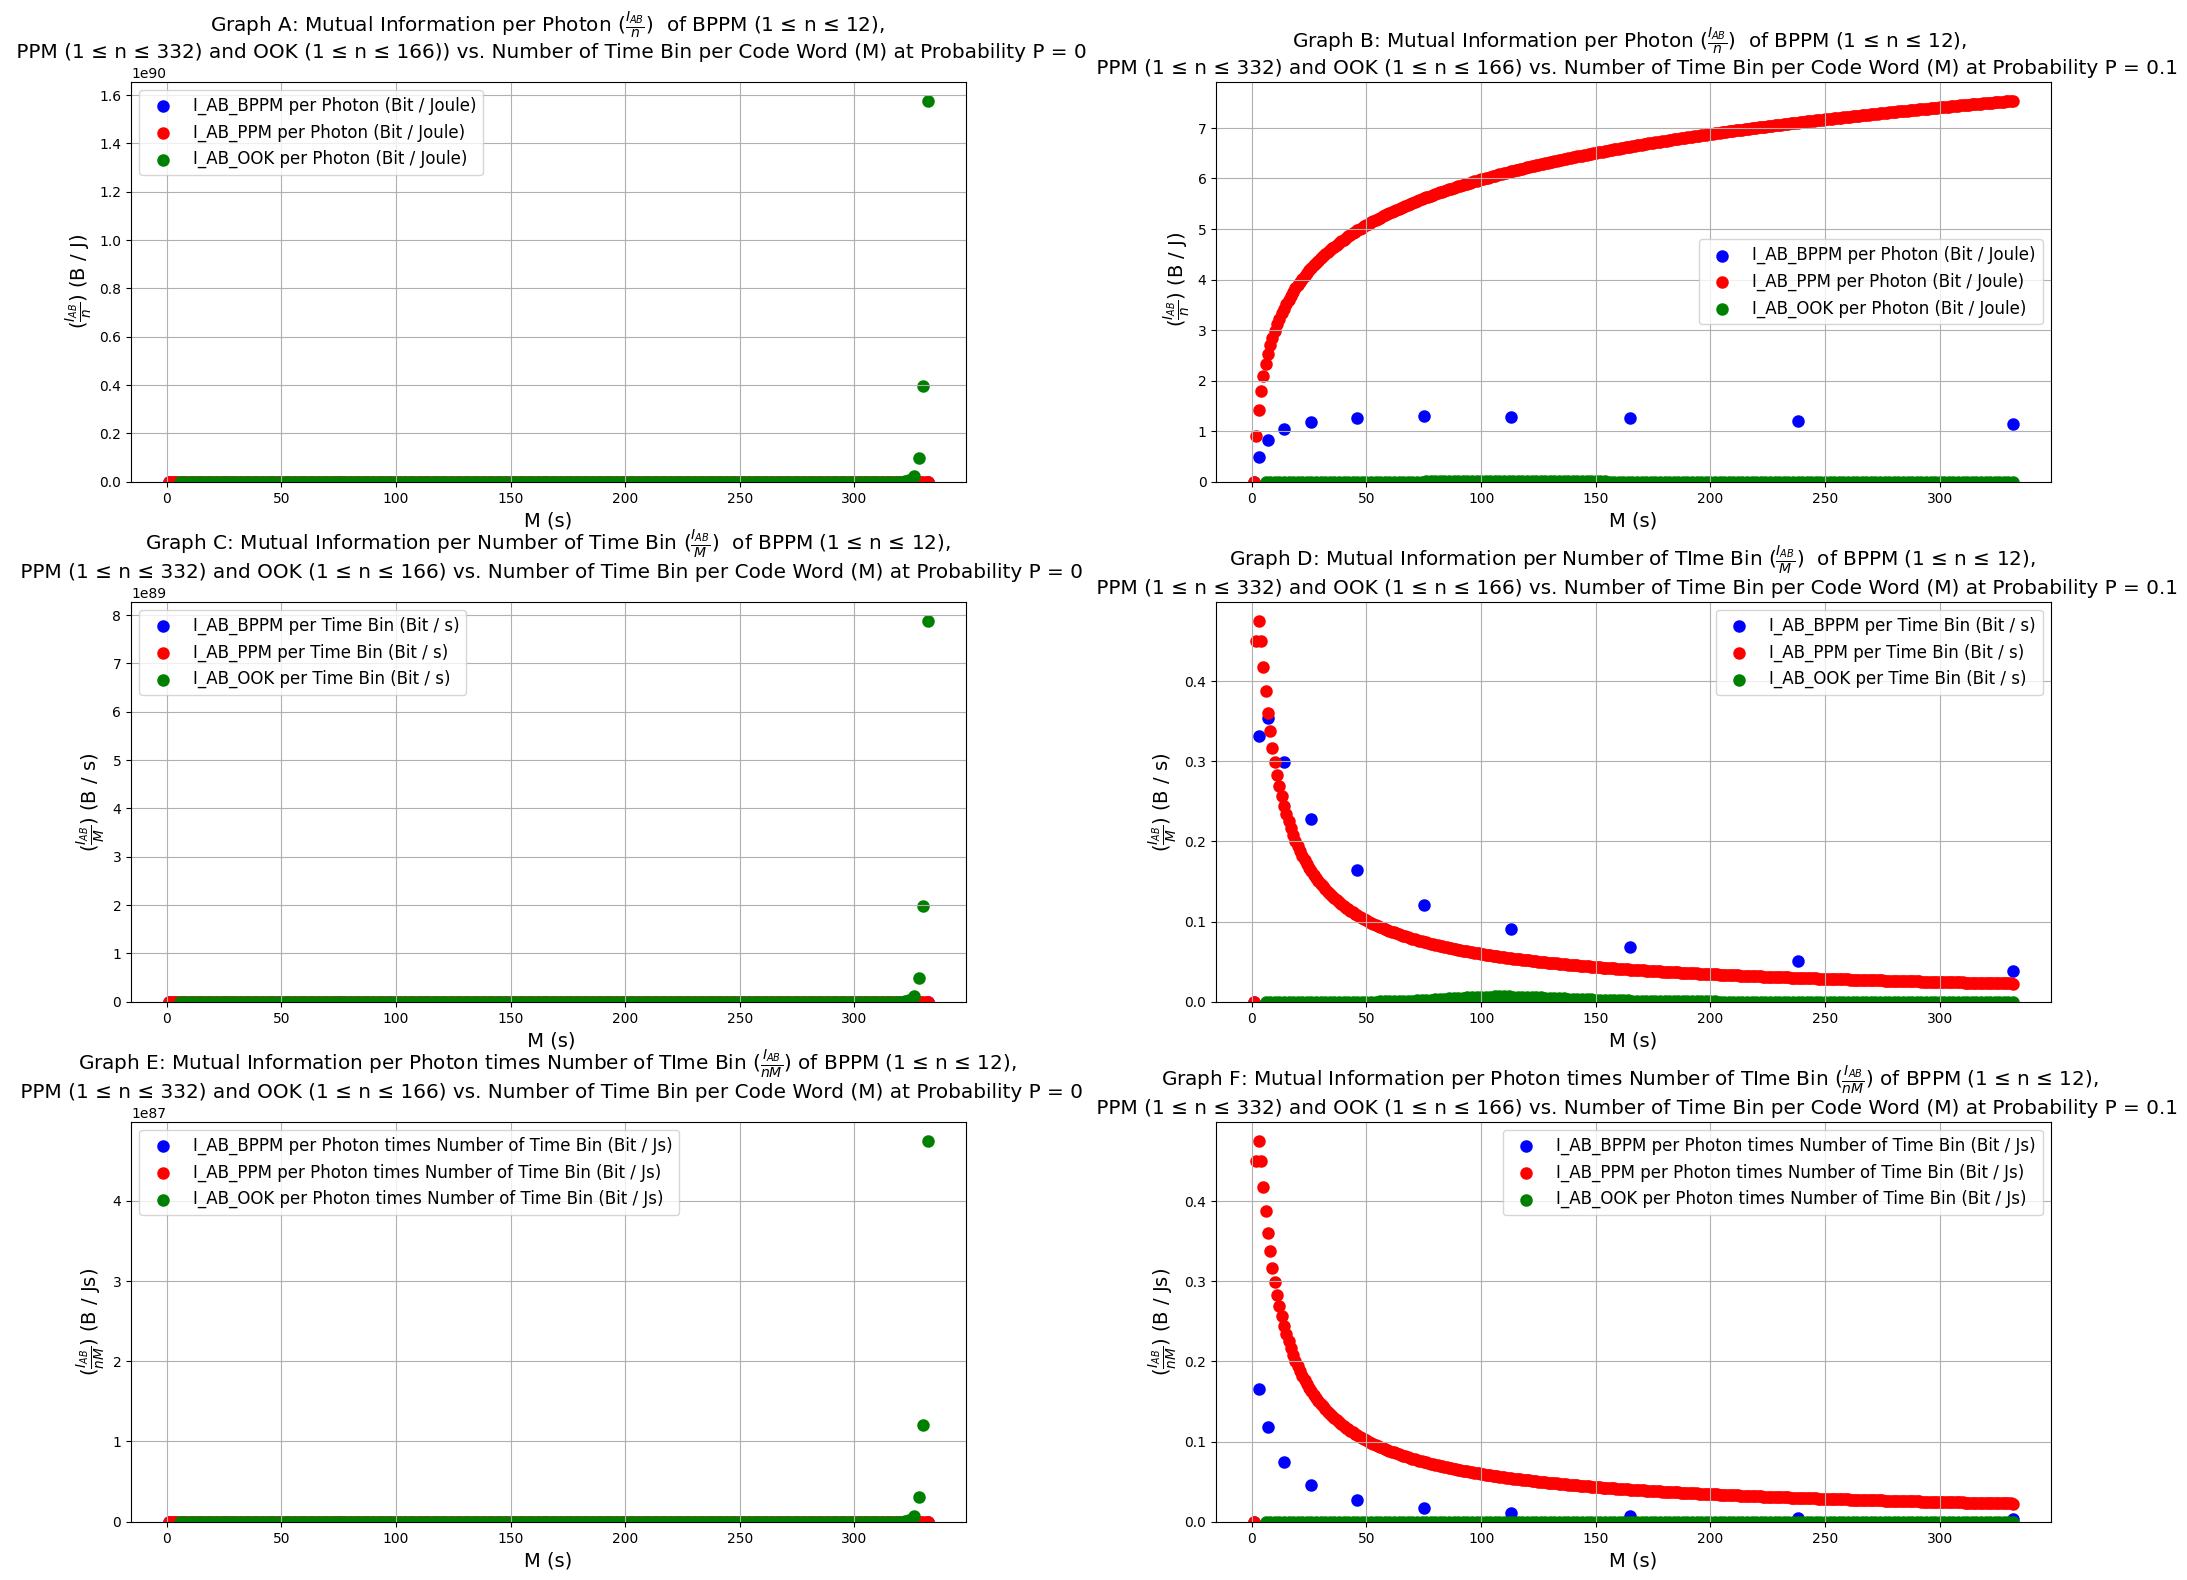

In [27]:
figure, axis = plt.subplots(3,2,figsize=(24,18))


axis[0, 0].scatter(TimeBin_BPPM_list_0, IperPhoton_AB_BPPM_list_0, label='I_AB_BPPM per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_PPM_list_0, IperPhoton_AB_PPM_list_0, label='I_AB_PPM per Photon (Bit / Joule)', color ='red', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photon (Bit / Joule)', color ='green', linewidth=3, alpha=1)
axis[0, 0].set_title('Graph A: Mutual Information per Photon ($\\frac{I_{AB}}{n}$)  of BPPM (1 \u2264 n \u2264 12), \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166)) vs. Number of Time Bin per Code Word (M) at Probability P = 0', fontsize='x-large')
axis[0, 0].set_xlabel('M (s)', fontsize = 14)
axis[0, 0].set_ylabel('($\\frac{I_{AB}}{n}$) (B / J)', fontsize = 14)
# axis[0, 0].set_xscale('log')
axis[0, 0].set_ylim(0)
axis[0, 0].grid(True)
axis[0, 0].legend(fontsize=12)



axis[0, 1].scatter(TimeBin_BPPM_list_0_1, IperPhoton_AB_BPPM_list_0_1, label='I_AB_BPPM per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_PPM_list_0_1, IperPhoton_AB_PPM_list_0_1, label='I_AB_PPM per Photon (Bit / Joule)', color ='red', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK per Photon (Bit / Joule)', color ='green', linewidth=3, alpha=1)
axs[2].scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 1].set_title('Graph B: Mutual Information per Photon ($\\frac{I_{AB}}{n}$)  of BPPM (1 \u2264 n \u2264 12),  \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0.1', fontsize='x-large')
axis[0, 1].set_xlabel('M (s)', fontsize = 14)
axis[0, 1].set_ylabel(' ($\\frac{I_{AB}}{n}$) (B / J)', fontsize = 14)
# axis[0, 1].set_xscale('log')
axis[0, 1].set_ylim(0)
axis[0, 1].grid(True)
axis[0, 1].legend(fontsize=12)

axis[1, 0].scatter(TimeBin_BPPM_list_0, IperTimeBin_AB_BPPM_list_0, label='I_AB_BPPM per Time Bin (Bit / s)', color ='blue', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_PPM_list_0, IperTimeBin_AB_PPM_list_0, label='I_AB_PPM per Time Bin (Bit / s)', color ='red', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_OOK_list_0, IperTimeBin_AB_OOK_list_0, label='I_AB_OOK per Time Bin (Bit / s)', color ='green', linewidth=3, alpha=1)
axis[1, 0].set_title('Graph C: Mutual Information per Number of Time Bin ($\\frac{I_{AB}}{M}$)  of BPPM (1 \u2264 n \u2264 12), \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0', fontsize='x-large')
axis[1, 0].set_xlabel(' M (s)', fontsize = 14)
axis[1, 0].set_ylabel('($\\frac{I_{AB}}{M}$) (B / s)', fontsize = 14)
# axis[1, 0].set_xscale('log')
axis[1, 0].set_ylim(0)
axis[1, 0].grid(True)
axis[1, 0].legend(fontsize=12)

axis[1, 1].scatter(TimeBin_BPPM_list_0_1, IperTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM per Time Bin (Bit / s)', color ='blue', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_PPM_list_0_1, IperTimeBin_AB_PPM_list_0_1, label='I_AB_PPM per Time Bin (Bit / s)', color ='red', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_OOK_list_0_1, IperTimeBin_AB_OOK_list_0_1, label='I_AB_OOK per Time Bin (Bit / s)', color ='green', linewidth=3, alpha=1)
axis[1, 1].set_title('Graph D: Mutual Information per Number of TIme Bin ($\\frac{I_{AB}}{M}$)  of BPPM (1 \u2264 n \u2264 12), \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0.1', fontsize='x-large')
axis[1, 1].set_xlabel('M (s)', fontsize = 14)
axis[1, 1].set_ylabel('($\\frac{I_{AB}}{M}$) (B / s)', fontsize = 14)
# axis[1, 1].set_xscale('log')
axis[1, 1].set_ylim(0)
axis[1, 1].grid(True)
axis[1, 1].legend(fontsize=12)

axis[2, 0].scatter(TimeBin_BPPM_list_0, IperPhotonTimeBin_AB_BPPM_list_0, label='I_AB_BPPM per Photon times Number of Time Bin (Bit / Js)', color ='blue', linewidth=3, alpha=1)
axis[2, 0].scatter(TimeBin_PPM_list_0, IperPhotonTimeBin_AB_PPM_list_0, label='I_AB_PPM per Photon times Number of Time Bin (Bit / Js)', color ='red', linewidth=3, alpha=1)
axis[2, 0].scatter(TimeBin_OOK_list_0, IperPhotonTimeBin_AB_OOK_list_0, label='I_AB_OOK per Photon times Number of Time Bin (Bit / Js)', color ='green', linewidth=3, alpha=1)
axis[2, 0].set_title('Graph E: Mutual Information per Photon times Number of TIme Bin ($\\frac{I_{AB}}{n M}$) of BPPM (1 \u2264 n \u2264 12), \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0', fontsize='x-large')
axis[2, 0].set_xlabel('M (s)', fontsize = 14)
axis[2, 0].set_ylabel('($\\frac{I_{AB}}{n M}$) (B / Js)', fontsize = 14)
# axis[2, 0].set_xscale('log')
axis[2, 0].set_ylim(0)
axis[2, 0].grid(True)
axis[2, 0].legend(fontsize=12)

axis[2, 1].scatter(TimeBin_BPPM_list_0_1, IperPhotonTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM per Photon times Number of Time Bin (Bit / Js)', color ='blue', linewidth=3, alpha=1)
axis[2, 1].scatter(TimeBin_PPM_list_0_1, IperPhotonTimeBin_AB_PPM_list_0_1, label='I_AB_PPM per Photon times Number of Time Bin (Bit / Js)', color ='red', linewidth=3, alpha=1)
axis[2, 1].scatter(TimeBin_OOK_list_0_1, IperPhotonTimeBin_AB_OOK_list_0_1, label='I_AB_OOK per Photon times Number of Time Bin (Bit / Js)', color ='green', linewidth=3, alpha=1)
axis[2, 1].set_title('Graph F: Mutual Information per Photon times Number of TIme Bin ($\\frac{I_{AB}}{n M}$) of BPPM (1 \u2264 n \u2264 12),  \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0.1', fontsize='x-large')
axis[2, 1].set_xlabel('M (s)', fontsize = 14)
axis[2, 1].set_ylabel('($\\frac{I_{AB}}{n M}$) (B / Js)', fontsize = 14)
# axis[2, 1].set_xscale('log')
axis[2, 1].set_ylim(0)
axis[2, 1].grid(True)
axis[2, 1].legend(fontsize=12)

figure.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
figure.set_facecolor("white")
# plt.savefig('protocol/3NewMetrics.png', dpi=450, bbox_inches='tight')
plt.show()

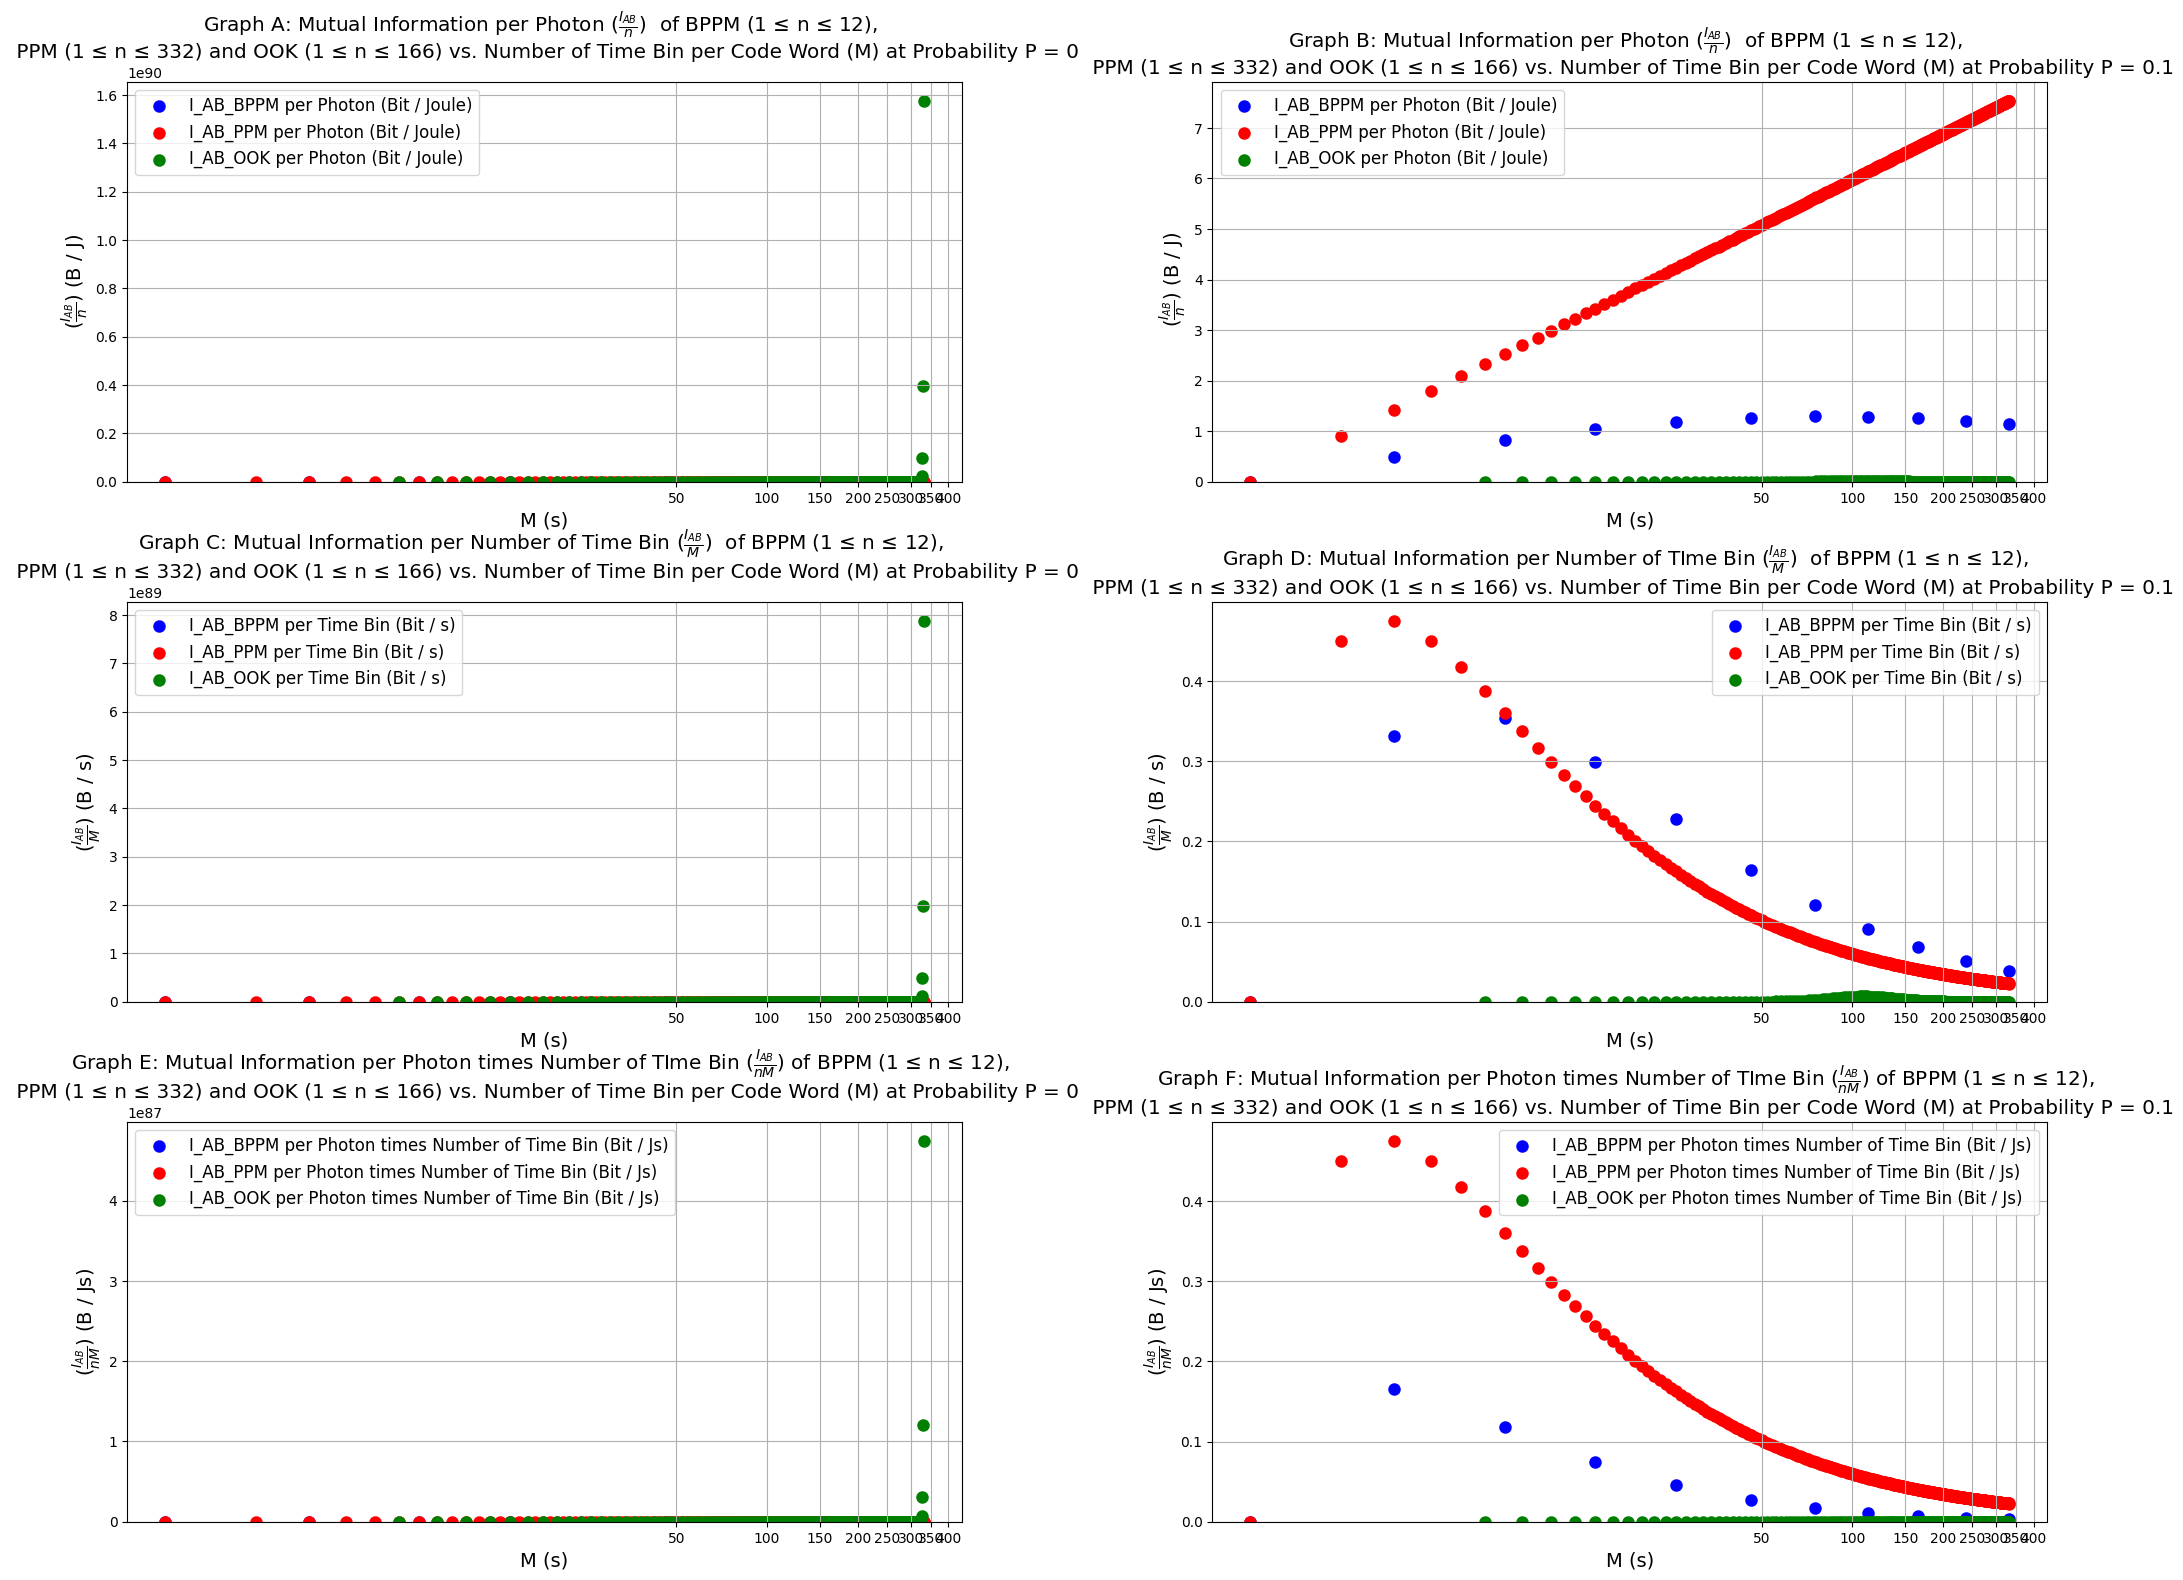

In [28]:
figure, axis = plt.subplots(3,2,figsize=(24,18))

axis[0, 0].scatter(TimeBin_BPPM_list_0, IperPhoton_AB_BPPM_list_0, label='I_AB_BPPM per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_PPM_list_0, IperPhoton_AB_PPM_list_0, label='I_AB_PPM per Photon (Bit / Joule)', color ='red', linewidth=3, alpha=1)
axis[0, 0].scatter(TimeBin_OOK_list_0, IperPhoton_AB_OOK_list_0, label='I_AB_OOK per Photon (Bit / Joule)', color ='green', linewidth=3, alpha=1)

axis[0, 0].set_xscale('log')
axis[0, 0].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[0, 0].xaxis.set_major_locator(AutoLocator())
axis[0, 0].xaxis.set_minor_locator(AutoMinorLocator())
axis[0, 0].xaxis.set_tick_params(which='both', labelsize=10)

axis[0, 0].set_title('Graph A: Mutual Information per Photon ($\\frac{I_{AB}}{n}$)  of BPPM (1 \u2264 n \u2264 12),  \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0', fontsize='x-large')
axis[0, 0].set_xlabel('M (s)', fontsize = 14)
axis[0, 0].set_ylabel('($\\frac{I_{AB}}{n}$) (B / J)', fontsize = 14)
axis[0, 0].set_ylim(0)
axis[0, 0].grid(True)
axis[0, 0].legend(fontsize=12)

axis[0, 1].scatter(TimeBin_BPPM_list_0_1, IperPhoton_AB_BPPM_list_0_1, label='I_AB_BPPM per Photon (Bit / Joule)', color ='blue', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_PPM_list_0_1, IperPhoton_AB_PPM_list_0_1, label='I_AB_PPM per Photon (Bit / Joule)', color ='red', linewidth=3, alpha=1)
axis[0, 1].scatter(TimeBin_OOK_list_0_1, IperPhoton_AB_OOK_list_0_1, label='I_AB_OOK per Photon (Bit / Joule)', color ='green', linewidth=3, alpha=1)

axis[0, 1].set_xscale('log')
axis[0, 1].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[0, 1].xaxis.set_major_locator(AutoLocator())
axis[0, 1].xaxis.set_minor_locator(AutoMinorLocator())
axis[0, 1].xaxis.set_tick_params(which='both', labelsize=10)

axis[0, 1].set_title('Graph B: Mutual Information per Photon ($\\frac{I_{AB}}{n}$)  of BPPM (1 \u2264 n \u2264 12),  \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0.1', fontsize='x-large')
axis[0, 1].set_xlabel('M (s)', fontsize = 14)
axis[0, 1].set_ylabel(' ($\\frac{I_{AB}}{n}$) (B / J)', fontsize = 14)
axis[0, 1].set_ylim(0)
axis[0, 1].grid(True)
axis[0, 1].legend(fontsize=12)

axis[1, 0].scatter(TimeBin_BPPM_list_0, IperTimeBin_AB_BPPM_list_0, label='I_AB_BPPM per Time Bin (Bit / s)', color ='blue', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_PPM_list_0, IperTimeBin_AB_PPM_list_0, label='I_AB_PPM per Time Bin (Bit / s)', color ='red', linewidth=3, alpha=1)
axis[1, 0].scatter(TimeBin_OOK_list_0, IperTimeBin_AB_OOK_list_0, label='I_AB_OOK per Time Bin (Bit / s)', color ='green', linewidth=3, alpha=1)

axis[1, 0].set_xscale('log')
axis[1, 0].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[1, 0].xaxis.set_major_locator(AutoLocator())
axis[1, 0].xaxis.set_minor_locator(AutoMinorLocator())
axis[1, 0].xaxis.set_tick_params(which='both', labelsize=10)

axis[1, 0].set_title('Graph C: Mutual Information per Number of Time Bin ($\\frac{I_{AB}}{M}$)  of BPPM (1 \u2264 n \u2264 12),  \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0', fontsize='x-large')
axis[1, 0].set_xlabel('M (s)', fontsize = 14)
axis[1, 0].set_ylabel('($\\frac{I_{AB}}{M}$) (B / s)', fontsize = 14)
axis[1, 0].set_ylim(0)
axis[1, 0].grid(True)
axis[1, 0].legend(loc = 'upper left', fontsize=12)

axis[1, 1].scatter(TimeBin_BPPM_list_0_1, IperTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM per Time Bin (Bit / s)', color ='blue', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_PPM_list_0_1, IperTimeBin_AB_PPM_list_0_1, label='I_AB_PPM per Time Bin (Bit / s)', color ='red', linewidth=3, alpha=1)
axis[1, 1].scatter(TimeBin_OOK_list_0_1, IperTimeBin_AB_OOK_list_0_1, label='I_AB_OOK per Time Bin (Bit / s)', color ='green', linewidth=3, alpha=1)

axis[1, 1].set_xscale('log')
axis[1, 1].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[1, 1].xaxis.set_major_locator(AutoLocator())
axis[1, 1].xaxis.set_minor_locator(AutoMinorLocator())
axis[1, 1].xaxis.set_tick_params(which='both', labelsize=10)

axis[1, 1].set_title('Graph D: Mutual Information per Number of TIme Bin ($\\frac{I_{AB}}{M}$)  of BPPM (1 \u2264 n \u2264 12),  \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0.1', fontsize='x-large')
axis[1, 1].set_xlabel('M (s)', fontsize = 14)
axis[1, 1].set_ylabel('($\\frac{I_{AB}}{M}$) (B / s)', fontsize = 14)
axis[1, 1].set_ylim(0)
axis[1, 1].grid(True)
axis[1, 1].legend(fontsize=12)

axis[2, 0].scatter(TimeBin_BPPM_list_0, IperPhotonTimeBin_AB_BPPM_list_0, label='I_AB_BPPM per Photon times Number of Time Bin (Bit / Js)', color ='blue', linewidth=3, alpha=1)
axis[2, 0].scatter(TimeBin_PPM_list_0, IperPhotonTimeBin_AB_PPM_list_0, label='I_AB_PPM per Photon times Number of Time Bin (Bit / Js)', color ='red', linewidth=3, alpha=1)
axis[2, 0].scatter(TimeBin_OOK_list_0, IperPhotonTimeBin_AB_OOK_list_0, label='I_AB_OOK per Photon times Number of Time Bin (Bit / Js)', color ='green', linewidth=3, alpha=1)

axis[2, 0].set_xscale('log')
axis[2, 0].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[2, 0].xaxis.set_major_locator(AutoLocator())
axis[2, 0].xaxis.set_minor_locator(AutoMinorLocator())
axis[2, 0].xaxis.set_tick_params(which='both', labelsize=10)

axis[2, 0].set_title('Graph E: Mutual Information per Photon times Number of TIme Bin ($\\frac{I_{AB}}{n M}$) of BPPM (1 \u2264 n \u2264 12),  \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0', fontsize='x-large')
axis[2, 0].set_xlabel('M (s)', fontsize = 14)
axis[2, 0].set_ylabel('($\\frac{I_{AB}}{n M}$) (B / Js)', fontsize = 14)
axis[2, 0].set_ylim(0)
axis[2, 0].grid(True)
axis[2, 0].legend(fontsize=12)

axis[2, 1].scatter(TimeBin_BPPM_list_0_1, IperPhotonTimeBin_AB_BPPM_list_0_1, label='I_AB_BPPM per Photon times Number of Time Bin (Bit / Js)', color ='blue', linewidth=3, alpha=1)
axis[2, 1].scatter(TimeBin_PPM_list_0_1, IperPhotonTimeBin_AB_PPM_list_0_1, label='I_AB_PPM per Photon times Number of Time Bin (Bit / Js)', color ='red', linewidth=3, alpha=1)
axis[2, 1].scatter(TimeBin_OOK_list_0_1, IperPhotonTimeBin_AB_OOK_list_0_1, label='I_AB_OOK per Photon times Number of Time Bin (Bit / Js)', color ='green', linewidth=3, alpha=1)

axis[2, 1].set_xscale('log')
axis[2, 1].xaxis.set_major_formatter(formatter)
# Set the tick locators and formatters for the x-axis
axis[2, 1].xaxis.set_major_locator(AutoLocator())
axis[2, 1].xaxis.set_minor_locator(AutoMinorLocator())
axis[2, 1].xaxis.set_tick_params(which='both', labelsize=10)

axis[2, 1].set_title('Graph F: Mutual Information per Photon times Number of TIme Bin ($\\frac{I_{AB}}{n M}$) of BPPM (1 \u2264 n \u2264 12),  \n PPM (1 \u2264 n \u2264 332) and OOK (1 \u2264 n \u2264 166) vs. Number of Time Bin per Code Word (M) at Probability P = 0.1', fontsize='x-large')
axis[2, 1].set_xlabel('M (s)', fontsize = 14)
axis[2, 1].set_ylabel('($\\frac{I_{AB}}{n M}$) (B / Js)', fontsize = 14)
axis[2, 1].set_ylim(0)
axis[2, 1].grid(True)
axis[2, 1].legend(fontsize=12)

figure.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.3, hspace=0.3)
figure.set_facecolor("white")
# plt.savefig('protocol/3NewMetricsLog.png', dpi=450, bbox_inches='tight')
plt.show()

P is the error probability per time bin and q = 1- p is the probability for correct transmission per time bin

(P Success and P Detection)
For M = 1 ( 1 tiem bin per code word)


